# Imports, General Funcs and Drive Connection

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D, Masking
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedGroupKFold


# Convert sequences to one-hot encoding + Padd To Max Seq
def one_hot_encode(sequences,max_length):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # List of all possible amino acids
    one_hot_dict = {aa: [1 if aa == base else 0 for base in amino_acids] for aa in amino_acids}
    one_hot_sequences = []
    for seq in sequences:
      seq_array = []
      for aa in seq:
        seq_array.append(one_hot_dict[aa])
      seq_array.extend([[0]*20]*(max_length-len(seq)))
      one_hot_sequences.append(np.array(seq_array))
    one_hot_sequences = np.array(one_hot_sequences)
    return one_hot_sequences


def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    all_labels = []
    with open(filename, 'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
                all_labels.append(line[1:].replace('\n', '').replace('\r', ''))
            else:
                current_seq += line.replace('\n', '').replace('\r', '')
                count += 1
        all_seqs.append(current_seq)
        all_seqs = np.array(all_seqs[1:])
        all_seqs = np.array(all_seqs)
    return all_seqs, np.array(all_labels)


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prep Data

## Generate df_CNN

In [3]:
# Generate df_CNN
import random

def gen_df_cnn():
    # ordered_proteins, ordered_protein_labels = load_FASTA(r'cath.fasta')
    # print(type(ordered_proteins))
    # print(ordered_protein_labels[:5])
    disordered_proteins, disordered_protein_labels = load_FASTA(r'drive/MyDrive/sadna/data/disprot.fasta')
    globular_proteins, globular_proteins_labels = load_FASTA(r'drive/MyDrive/sadna/data/cath.fasta')

    random.seed(42)
    random.shuffle(globular_proteins)

    prion_db = pd.read_csv(r"drive/MyDrive/sadna/data/prion_db.csv")
    print(f"Number of prion seqs: {len(prion_db)}\n")
    prions = prion_db["Sequence"]

    non_prions = list(disordered_proteins) + list(globular_proteins[:2000])

    is_prion_col = [1 for seq in prions] + [0 for seq in non_prions]
    seq_col = list(prions) + list(non_prions)

    df_CNN = pd.DataFrame({"Sequence": seq_col, "Prion?": is_prion_col})
    df_CNN = df_CNN.drop_duplicates()
    df_CNN = df_CNN[~df_CNN['Sequence'].str.contains('[*#XBZU]')]

    df_CNN["seq_len"] = df_CNN["Sequence"].apply(lambda seq: len(seq))
    print(f"df_CNN samples count before length filter: {len(df_CNN)}")
    len_lim = 40
    df_CNN = df_CNN[df_CNN["seq_len"] > len_lim]

    # df_CNN = df_CNN.head()
    print(f"df_CNN samples count after length filter: {len(df_CNN)}")
    df_CNN.to_csv(r"drive/MyDrive/sadna/data/df_CNN_full.csv", index=False)

gen_df_cnn()


Number of prion seqs: 1697

df_CNN samples count before length filter: 7970
df_CNN samples count after length filter: 4904


## Basic Analysis of Prions and Disordered

### AA Frequencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    all_labels = []
    with open(filename, 'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
                all_labels.append(line[1:].replace('\n', '').replace('\r', ''))
            else:
                current_seq += line.replace('\n', '').replace('\r', '')
                count += 1
        all_seqs.append(current_seq)
        all_seqs = np.array(all_seqs[1:])
        all_seqs = np.array(all_seqs)
    return all_seqs, np.array(all_labels)


# ordered_proteins, ordered_protein_labels = load_FASTA(r'cath.fasta')
# print(type(ordered_proteins))
# print(ordered_protein_labels[:5])
disordered_proteins, disordered_protein_labels = load_FASTA(r'drive/MyDrive/sadna/data/disprot.fasta')

prion_db = pd.read_csv(r"drive/MyDrive/sadna/data/prion_db.csv")
print(f"Number of prion seqs: {len(prion_db)}\n")
prions = prion_db["Sequence"]
# print(prion_db["Sequence Length"].mean())


print('Sample prion:\n' ,prions[10])
print()
print('Sample disordered protein:\n' ,disordered_proteins[10])
print()

print('Number of ordered protein sequences: %s' % len(prions))
print('Number of disordered protein sequences: %s' % len(disordered_proteins))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
list_amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
      'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y']

def aa_content_feature_map(sequence):
  counts = np.zeros(len(list_amino_acids))
  L = len(sequence)
  for s in sequence:
    try:
      counts[list_amino_acids.index(s)] += 1
    except: # If unknown amino acid, will trigger exception. Ignore
      continue
  frequencies = counts / counts.sum()
  return frequencies


prions_features = [aa_content_feature_map(sequence) for sequence in prions]
disordered_proteins_features = [aa_content_feature_map(sequence) for sequence in disordered_proteins]


table = pd.DataFrame(data=prions_features + disordered_proteins_features, columns = ['%s_freq'%x for x in list_amino_acids])
table['Length'] = [len(sequence) for sequence in prions] + [len(sequence) for sequence in disordered_proteins]
table['Prion'] = [1 for _ in range(len(prions))] + [0 for _ in range(len(disordered_proteins))]

table = table.sample(frac=1).reset_index(drop=True) # Shuffle rows


print(len(table))
table.head()



#### Frequencies visualization

In [ ]:
import seaborn as sns

sns.histplot(table,x='Length',hue="Prion", element="step",
    stat="density", common_norm=False);
plt.show()


fig, ax = plt.subplots(nrows=4,ncols=5,figsize=(20,16))
for k,aa in enumerate(list_amino_acids):
  sns.histplot(
    table, x="%s_freq"%aa, hue="Prion", element="step",
    stat="density", common_norm=False,ax=ax[k//5,k%5]
)
plt.tight_layout()
plt.show()

All ordered proteins are above a certain length... Focus on long sequences only

In [ ]:
# Lmin = 50
Lmin = 40
subtable = table[table['Length'] >= Lmin]
print(f"Amount of samples after size filter > {Lmin}: {len(subtable)}")
print(f"Amount of prions left: {len(subtable[subtable['Prion'] == 1])}")
print(f"Amount of disordered left: {len(subtable[subtable['Prion'] == 0])}")


sns.histplot(subtable,x='Length',hue="Prion", element="step",
    stat="density", common_norm=False);
plt.show()


fig, ax = plt.subplots(nrows=4,ncols=5,figsize=(20,16))
for k,aa in enumerate(list_amino_acids):
  sns.histplot(
    subtable, x="%s_freq"%aa, hue="Prion", element="step",
    stat="density", common_norm=False,ax=ax[k//5,k%5]
)
plt.tight_layout()
plt.show()

###  Windows AA Frequencies

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm


def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    all_labels = []
    with open(filename, 'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
                all_labels.append(line[1:].replace('\n', '').replace('\r', ''))
            else:
                current_seq += line.replace('\n', '').replace('\r', '')
                count += 1
        all_seqs.append(current_seq)
        all_seqs = np.array(all_seqs[1:])
        all_seqs = np.array(all_seqs)
    return all_seqs, np.array(all_labels)


WINDOW_SIZE = 30
STRIDE = 1

list_amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
      'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y']


def calculate_aa_frequencies(sequence, window_start, window_end):
    aa_count = {}
    total_aa = len(sequence)

    for aa in sequence:
        if aa in aa_count:
            aa_count[aa] += 1
        else:
            aa_count[aa] = 1

    frequencies = {f"{aa}_freq_{window_start}_{window_end}": aa_count.get(aa, 0) / total_aa for aa in "ACDEFGHIKLMNPQRSTVWY"}
    return frequencies


padding_char = '#'
def pad_sequence(seq, window_size):
    if len(seq) < window_size:
        padding_length = window_size - len(seq)
        padded_seq = seq + padding_char * padding_length
    else:
        padded_seq = seq
    return padded_seq


def aa_freq_by_windows(seqs: 'pd.Series[List[str]]',
                       window_start: int = 0,
                       window_size: int = WINDOW_SIZE,
                       stride: int = STRIDE) -> pd.DataFrame:

    d = {}
    all_freq_res = []

    seq_lengths = seqs.apply(lambda seq: len(seq))
    while window_start <= seq_lengths.max() - window_size:
        partial_seqs = seqs.apply(lambda seq: pad_sequence(seq[window_start:window_start + window_size], window_size))
        freq_res = partial_seqs.apply(lambda x: pd.Series(calculate_aa_frequencies(x, window_start, window_start + window_size)))
        all_freq_res.append(freq_res)
        window_start += stride

    # final_df = pd.concat(all_freq_res, axis=1)
    # final_df.insert(0, 'Sequence', seqs)
    final_df = pd.concat([seqs] + all_freq_res, axis=1)

    return final_df


def gen_total_feature_df():
    # ordered_proteins, ordered_protein_labels = load_FASTA(r'cath.fasta')
    # print(type(ordered_proteins))
    # print(ordered_protein_labels[:5])
    # disordered_proteins, disordered_protein_labels = load_FASTA(r'..\data\disprot.fasta')
    disordered_proteins, disordered_protein_labels = load_FASTA(r'disprot.fasta')

    # prion_db = pd.read_csv(r"..\data\prion_db.csv")
    prion_db = pd.read_csv(r"prion_db.csv")
    print(f"Number of prion seqs: {len(prion_db)}\n")
    prions = prion_db["Sequence"]

    is_prion_col = [1 for seq in prions] + [0 for seq in disordered_proteins]
    seq_col = list(prions) + list(disordered_proteins)

    df_CNN = pd.DataFrame({"Sequence": seq_col, "Prion?": is_prion_col})
    df_CNN = df_CNN.drop_duplicates()
    df_CNN = df_CNN[~df_CNN['Sequence'].str.contains('[*#XBZ]')]

    df_CNN["seq_len"] = df_CNN["Sequence"].apply(lambda seq: len(seq))
    print(f"df_CNN samples count before length filter: {len(df_CNN)}")
    len_lim = 40
    df_CNN = df_CNN[df_CNN["seq_len"] > len_lim]
    # df_CNN.to_csv("df_CNN.csv")
    # df_CNN = df_CNN.head()
    print(f"df_CNN samples count after length filter: {len(df_CNN)}")
    res_df = aa_freq_by_windows(df_CNN["Sequence"])
    res_df.to_csv("windows_features.csv")
    return res_df



In [ ]:
window_features_df = pd.read_csv("prions_and_disordered.csv")
subtable = window_features_df.sample(frac=1).reset_index(drop=True) # Shuffle rows

print(subtable.head())

#### Run Logisitic Regression on Window Freqs

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


L = len(subtable)
train_fraction = 0.8
test_fraction = 0.2

Ltrain = int(L*train_fraction)
train_table = subtable[:Ltrain]
test_table = subtable[Ltrain:]

# from sklearn.model_selection import StratifiedGroupKFold

# X_mat = subtable['Sequence']
# y_vec = subtable['Prion?']
# components = subtable['Component']
# sgkf1 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) # 5 non-overlapping tests, meaning around 20% test - 80% train each
# sgkf_split1 = sgkf.split(X_mat, y_vec, components) # splits while stratifying y and keeping same components together


# data_split1 = [[tr_index, te_index] for i, (tr_index, te_index) in enumerate(sgkf_split1)]
# tr_index, te_index = data_split1[0]


# train_table, test_table = X_mat.loc[tr_index], X_mat.loc[te_index]
# y_tr, y_te = y_vec[tr_index], y_vec[te_index]


features_columns = [c for c in subtable.columns if "freq" in c]
train_features = train_table[features_columns]
test_features = test_table[features_columns]

train_labels = train_table['Prion?']
test_labels  = test_table['Prion?']

print(train_features.head())
print(train_labels.head())

nan_df = train_features[train_features.isna().any(axis=1)]
print(f"Nans in train fatures: {nan_df}")


lambda_l2 = 1. # Regularization strength
classifier = LogisticRegression(max_iter=1000, C=1/lambda_l2, verbose=True)
classifier.fit(train_features, train_labels)

predictions = classifier.predict(test_features)

cm = confusion_matrix(test_labels,predictions)
disp=ConfusionMatrixDisplay(cm,display_labels=['Disordered','Prion'])
disp.plot()
plt.show()

print('Accuracy:%s' % (accuracy_score(test_labels, predictions)))



In [ ]:
coefficients = classifier.coef_[0]

# Assuming 'feature_names' is a list of feature names
feature_importance = pd.DataFrame({'Feature': features_columns, 'Coefficient': coefficients})

# Sort the coefficients by absolute value to see the most important features
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)
print(len(feature_importance))
feature_importance = feature_importance[feature_importance["Coefficient"] != 0]
print(len(feature_importance))

print(feature_importance.head(50))

#### run RandomForest on Windows Freqs

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

classifier = RandomForestClassifier(verbose=True)
classifier.fit(train_features, train_labels)

predictions = classifier.predict(test_features)

cm = confusion_matrix(test_labels,predictions)
disp = ConfusionMatrixDisplay(cm,display_labels=['Disordered', 'Prion'])
disp.plot()
plt.show()

print('Accuracy:%s'%(accuracy_score(test_labels,predictions)))


# Get feature importances
feature_importances = classifier.feature_importances_

# Get feature names (assuming train_features is a DataFrame)
feature_names = train_features.columns

# Sort feature importances by importance values
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Print top 20 important features
print("Top 20 important features:")
for i in range(20):
    print(f"Feature '{sorted_feature_names[i]}': Importance = {sorted_importances[i]}")

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names[:20], sorted_importances[:20])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.xticks(rotation=90)
plt.show()

## Keras Prep

In [3]:
!pip install keras

In [4]:
!pip install tensorflow


## First Keras Attempts (Irrelevant)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D, Masking
from keras.utils import to_categorical

# Convert sequences to one-hot encoding + Padd To Max Seq
def one_hot_encode(sequences,max_length):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # List of all possible amino acids
    one_hot_dict = {aa: [1 if aa == base else 0 for base in amino_acids] for aa in amino_acids}
    one_hot_sequences = []
    for seq in sequences:
      seq_array = []
      for aa in seq:
        seq_array.append(one_hot_dict[aa])
      seq_array.extend([[0]*20]*(max_length-len(seq)))
      one_hot_sequences.append(np.array(seq_array))
    one_hot_sequences = np.array(one_hot_sequences)
    return one_hot_sequences

# # Load data
# sequences = df_CNN['Sequence'].values
# labels = df_CNN['Prion?'].values

# One-hot encode sequences
max_length = df_CNN['Sequence'].str.len().max()
X_train_one_hot_sequences = one_hot_encode(X_train.values,max_length)
X_eval_one_hot_sequences = one_hot_encode(X_eval.values,max_length)
X_test_one_hot_sequences = one_hot_encode(X_test.values,max_length)
# # Convert labels to binary
# labels = labels.astype(int)

# # Split the data (60% train, 20% validation, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.4, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Build the CNN model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 20)))  # Masking layer for variable length sequences
model.add(AveragePooling1D(pool_size=30, strides=1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=10, batch_size=16, validation_data=(X_eval_one_hot_sequences, y_eval.values.astype(int)))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test_one_hot_sequences)

# Convert predictions to binary classes (thresholding at 0.5 for sigmoid activation)
y_pred = y_pred > 0.5

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


disp=ConfusionMatrixDisplay(cm,display_labels=['Disordered','Prion'])
disp.plot()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from keras.models import Model

# Get the weights of the first convolutional layer
conv_layer = model.layers[2]  # Assuming the convolutional layer is the third layer in your model
filters, biases = conv_layer.get_weights()

# Calculate the grid size dynamically based on the number of filters
n_filters = filters.shape[2]
cols = 8
rows = (n_filters + cols - 1) // cols

# Plot the filters
plt.figure(figsize=(cols * 2, rows * 2))
for i in range(n_filters):
    f = filters[:, :, i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(f, cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.show()


In [ ]:
model.get_weights()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select a sample input sequence from your dataset (e.g., X_train)
sample_sequence = X_train[0]  # Change the index as needed

# Get the activations of the filters for the sample sequence
activation_model = Model(inputs=model.input, outputs=model.layers[2].output)  # Assuming the convolutional layer is the third layer
activations = activation_model.predict(np.expand_dims(sample_sequence, axis=0))

# Plot the activations of each filter
n_filters = activations.shape[-1]
plt.figure(figsize=(15, 5))
for i in range(n_filters):
    plt.subplot(1, n_filters, i+1)
    plt.plot(activations[0, :, i])
    plt.title(f'Filter {i+1} Activation')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Activation')
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap

In [ ]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for a sample of data (e.g., the first 10 samples)
shap_values = explainer(X_train)

# Visualize the SHAP values
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
shap.summary_plot(shap_values, X_train, feature_names=amino_acids)


## Homologs Prep Using MMSEQ and graph components

### Installing Conda and MMSEQS2



In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


In [6]:
!conda create --name envn python=3.10.13
!conda activate envn

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/envn

  added / updated specs:
    - python=3.10.13


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    libgcc-ng-13.2.0           |       h807b86a_5         752 KB  conda-forge
    libgomp-13.2.0             |       h807b86a_5         410 KB  conda-forge
    libsqlite-3.45.2           |       h2797004_0         837 KB  conda-forge
    libxcrypt-4.4.36           |       hd590300_1          98 KB  conda-forge
    openssl-3.2.1              |       hd590300_0         2.7 MB  conda-forge
    pip-24.0

In [ ]:
!conda install -c conda-forge -c bioconda mmseqs2

### MMseqs2 Old Runs

Creating with mmseqs2->east-cluster method clusters of 70% identical sequences for each fasta file.
- Note: we dont join the 2 fastas in order to keep the conserved sequences between the 2

In [ ]:
!mmseqs easy-cluster protein_data.fasta protein_cluster_output tmp_dir --min-seq-id 0.7

In [ ]:
!mmseqs easy-cluster disprot.fasta disprot_cluster_output tmp_dir --min-seq-id 0.7

In [ ]:
!mmseqs easy-cluster prion_db.fasta prion_cluster_output tmp_dir --min-seq-id 0.7

### Prep fasta from csv

In [ ]:
import pandas as pd

def convert_csv_to_fasta(input_csv, output_fasta, header_column, sequence_column):
    df = pd.read_csv(input_csv)
    with open(output_fasta, 'w') as f:
        for index, row in df.iterrows():
            # header = ">" + str(row[header_column]) + "\n"
            header = f">protein_{index}\n"
            sequence = str(row[sequence_column]) + "\n"
            f.write(header)
            f.write(sequence)

# convert_csv_to_fasta('prion_db.csv', 'prion_db.fasta', 'PrionHome Id', 'Sequence')
# convert_csv_to_fasta('df_CNN.csv', 'protein_data.fasta', 'PrionHome Id', 'Sequence')
convert_csv_to_fasta(r'drive/MyDrive/sadna/data/df_CNN_full.csv', r'drive/MyDrive/sadna/data/all_protein_data.fasta', 'PrionHome Id', 'Sequence')


### MMSEQ Run all data

In [ ]:
!mmseqs easy-cluster drive/MyDrive/sadna/data/all_protein_data.fasta drive/MyDrive/sadna/data/mmseq/protein_cluster_output tmp_dir --min-seq-id 0.7

### Create the graphs and clusters from mmseq output

In [ ]:
import pandas as pd

df = pd.read_csv(r"drive/MyDrive/sadna/data/mmseq/protein_cluster_output_cluster.tsv", sep="\t", names=["cluster_id", "seq_id"])
print(len(df))

print(df.head())
print(len(df["cluster_id"].unique()))
print(len(df["seq_id"].unique()))

#### Create components in graph

In [ ]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def parse_cluster_output(cluster_output_file):
    clusters = {}
    with open(cluster_output_file, 'r') as f:
        for line in f:
            cluster_id, seq_id = line.split()
            if cluster_id not in clusters:
                clusters[cluster_id] = []
            clusters[cluster_id].append(seq_id)
    return clusters

def create_graph(clusters, identity_threshold=0.7):
    G = nx.Graph()
    for cluster_id, seq_ids in clusters.items():
      for seq in seq_ids:
        G.add_node(seq)
      for i in range(len(seq_ids)):
          for j in range(i+1, len(seq_ids)):
              G.add_edge(seq_ids[i], seq_ids[j])
    return G

In [ ]:
cluster_output_file = 'drive/MyDrive/sadna/data/mmseq/protein_cluster_output_cluster.tsv'
clusters = parse_cluster_output(cluster_output_file)
G = create_graph(clusters)
res = nx.connected_components(G)
res = list(res)
print(res)
print(len(res))

In [ ]:
counter = 0
for com in res:
  for prot in com:
    counter+=1
counter

#### Add component column to df_CNN

In [ ]:
import pandas as pd
df_CNN = pd.read_csv("drive/MyDrive/sadna/data/df_CNN_full.csv")
df_CNN["Component"] = 0

In [ ]:
for i,component in enumerate(res):
  for protein in component:
    protien_index = int(protein.split('_')[1])
    df_CNN.loc[protien_index,"Component"] = i

In [ ]:
df_CNN.head()
df_CNN.to_csv('drive/MyDrive/sadna/data/df_CNN_Clustered.csv')

# CNN Analysis

We are going to run 2 versions of CNN on 2 datasets. So in total we will have 4 models. <br/><br/>

Dataset 1: prions + disordered proteins

Dataset 2: prions + disordered proteins + globular_proteins <br/><br/>

CNN 1: basic CNN (simulating logisitic regression) without conv layer

CNN 2: CNN with one conv layer




### Jerome's Filter Visualization Code (from github)

In [ ]:
"""
 Copyright 2020 - by Jerome Tubiana (jertubiana@gmail.com)
     All rights reserved

     Permission is granted for anyone to copy, use, or modify this
     software for any uncommercial purposes, provided this copyright
     notice is retained, and note is made of any changes that have
     been made. This software is distributed without any warranty,
     express or implied. In no event shall the author or contributors be
     liable for any damage arising out of the use of this software.

     The publication of research using this software, modified or not, must include
     appropriate citations to:
"""

import numpy as np
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import copy
import os

## Implementation inspired from https://stackoverflow.com/questions/42615527/sequence-logos-in-matplotlib-aligning-xticks
## Color choice inspired from: http://weblogo.threeplusone.com/manual.html

def get_ax(ax,i,nrows,ncols):
    if (ncols>1) & (nrows>1):
        col = i%ncols
        row = i//ncols
        ax_ = ax[row,col]
    elif (ncols>1) & (nrows==1):
        ax_ = ax[i]
    elif (ncols==1) & (nrows>1):
        ax_ = ax[i]
    else:
        ax_ = ax
    return ax_


def select_sites( W,  window = 5, theta_important = 0.25 ):
    n_sites = W.shape[0]
    norm = np.abs(W).sum(-1)
    important = np.nonzero(norm/norm.max() > theta_important)[0]
    selected = []
    for imp in important:
        selected += range( max(0,imp-window), min(imp+window+1,n_sites ) )
    selected = np.unique(selected)
    return selected

def ticksAt(selected,ticks_every=10):
    n_selected = len(selected)
    all_ticks = []
    all_ticks_labels = []
    previous_select = selected[0]
    k = 0
    for select in selected:
        if (select-previous_select)>1:
            k+=1
        if (select%ticks_every==0) | ((select-previous_select)>1):
            if not k in all_ticks:
                all_ticks.append(k+1)
                all_ticks_labels.append(select+1)
        previous_select = copy.copy(select)
        k+=1
    return np.array(all_ticks), np.array(all_ticks_labels)




def breaksAt(x,maxi_size,ax):
    ax.plot([x,x],[-maxi_size,maxi_size],linewidth=5,c='black',linestyle='--')



def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def aa_color(letter):
    if letter in ['C']:
        return 'green'
    elif letter in ['F','W','Y']:
        return [199/256., 182/256., 0.,1.]#'gold'
    elif letter in ['Q','N','S','T']:
        return 'purple'
    elif letter in ['V','L','I','M']:
        return 'black'
    elif letter in ['K','R','H']:
        return 'blue'
    elif letter in  ['D','E']:
        return 'red'
    elif letter in ['A','P','G']:
        return 'grey'
    elif letter in ['$\\boxminus$']:
        return 'black'
    else:
        return 'black'



def build_scores(matrix,epsilon = 1e-4):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    all_scores = []
    for site in range(n_sites):
        conservation = np.log2(21) + (np.log2(matrix[site]+epsilon) * matrix[site]).sum()
        liste = []
        order_colors = np.argsort(matrix[site])
        for c in order_colors:
            liste.append( (list_aa[c],matrix[site,c] * conservation) )
        all_scores.append(liste)
    return all_scores


def build_scores2(matrix):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    epsilon = 1e-4
    all_scores = []
    for site in range(n_sites):
        liste = []
        c_pos = np.nonzero(matrix[site] >= 0)[0]
        c_neg = np.nonzero(matrix[site] < 0)[0]

        order_colors_pos = c_pos[np.argsort(matrix[site][c_pos])]
        order_colors_neg = c_neg[np.argsort(-matrix[site][c_neg])]
        for c in order_colors_pos:
            liste.append( (list_aa[c],matrix[site,c],'+') )
        for c in order_colors_neg:
            liste.append( (list_aa[c],-matrix[site,c],'-') )
        all_scores.append(liste)
    return all_scores

def build_scores_break(matrix, selected,epsilon=1e-4):
    has_breaks = (selected[1:] - selected[:-1])>1
    has_breaks = np.concatenate((np.zeros(1),has_breaks) ,axis=0)
    n_sites = len(selected)
    n_colors = matrix.shape[1]

    epsilon = 1e-4
    all_scores = []
    maxi_size = 0
    for site,has_break in zip(selected,has_breaks):
        if has_break:
            all_scores.append([('BREAK','BREAK','BREAK')] )
#             all_scores.append([('BREAK','BREAK','BREAK')] )
        conservation = np.log2(21) + (np.log2(matrix[site]+epsilon) * matrix[site]).sum()
        liste = []
        order_colors = np.argsort(matrix[site])
        for c in order_colors:
            liste.append( (list_aa[c],matrix[site,c] * conservation) )
        maxi_size = max(maxi_size, conservation)
        all_scores.append(liste)
    return all_scores,maxi_size


def build_scores2_break(matrix, selected):
    has_breaks = (selected[1:] - selected[:-1])>1
    has_breaks = np.concatenate((np.zeros(1),has_breaks) ,axis=0)
    n_sites = len(selected)
    n_colors = matrix.shape[1]

    epsilon = 1e-4
    all_scores = []
    for site,has_break in zip(selected,has_breaks):
        if has_break:
            all_scores.append([('BREAK','BREAK','BREAK')] )
        liste = []
        c_pos = np.nonzero(matrix[site] >= 0)[0]
        c_neg = np.nonzero(matrix[site] < 0)[0]

        order_colors_pos = c_pos[np.argsort(matrix[site][c_pos])]
        order_colors_neg = c_neg[np.argsort(-matrix[site][c_neg])]
        for c in order_colors_pos:
            liste.append( (list_aa[c],matrix[site,c],'+') )
        for c in order_colors_neg:
            liste.append( (list_aa[c],-matrix[site,c],'-') )
        all_scores.append(liste)
    maxi_size = np.abs(matrix).sum(-1).max()
    return all_scores,maxi_size



fp = FontProperties(family="Arial", weight="bold")
globscale = 1.35
list_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W','Y','$\\boxminus$']
LETTERS = dict([ (letter, TextPath((-0.30, 0), letter, size=1, prop=fp) )   for letter in list_aa] )
COLOR_SCHEME = dict( [(letter,aa_color(letter)) for letter in list_aa] )

def Sequence_logo(matrix, ax = None,data_type=None,figsize=None,ylabel = None,title=None,epsilon=1e-4,show=True,
                  nrows=1,ticks_every=1,ticks_labels_size=14,title_size=20, x_start =0,x_stop=None):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'

    if ax is not None:
        show = False
        return_fig = False
    else:
        if figsize is None:
            figsize = (  max(int(0.3 * matrix.shape[0])/nrows, 2)  ,  3*nrows)
        fig, ax = plt.subplots(nrows,1,figsize=figsize)
        return_fig = True

    if nrows>1:
        siz = int( np.ceil(matrix.shape[0]/nrows) )
        minis = []
        maxis = []
        for row in range(nrows):
            if row < nrows-1:
                matrix_ = matrix[row*siz:(row+1)*siz]
            else:
                matrix_ = np.zeros( [siz, matrix.shape[-1] ] )
                matrix_[: len(matrix[row*siz:]) ] = matrix[row*siz:]
            if row == 0:
                ylabel_ = ylabel
                title_ = title
            else:
                ylabel_ = '...'
                title_ = ''
            Sequence_logo(matrix_,ax=ax[row], figsize = figsize, ticks_every=ticks_every,
                          ticks_labels_size=ticks_labels_size, title_size=title_size,
                          show=False, ylabel = ylabel_, title = title_,
                          data_type=data_type, x_start = row*siz,nrows=1)
            minis.append(ax[row].get_ylim()[0])
            maxis.append(ax[row].get_ylim()[1])

        for row in range(nrows):
            ax[row].set_ylim([min(minis),max(maxis)])

    else:
        if data_type == 'mean':
            all_scores = build_scores(matrix,epsilon=epsilon)
        elif data_type =='weights':
            all_scores = build_scores2(matrix)
        else:
            print('data type not understood')
            return -1

        x = 1
        maxi = 0
        mini = 0
        for scores in all_scores:
            if data_type == 'mean':
                y = 0
                for base, score in scores:
                    if score > 0.01:
                        letterAt(base, x,y, score, ax)
                    y += score
                x += 1
                maxi = max(maxi, y)


            elif data_type =='weights':
                y_pos = 0
                y_neg = 0
                for base,score,sign in scores:
                    if sign == '+':
                        letterAt(base, x,y_pos, score, ax)
                        y_pos += score
                    else:
                        y_neg += score
                        letterAt(base, x,-y_neg, score, ax)
                x += 1
                maxi = max(y_pos,maxi)
                mini = min(-y_neg,mini)

        if data_type == 'weights':
            maxi = max(  maxi, abs(mini) )
            mini = -maxi

        if ticks_every > 1:
            xticks = range(1,x)
            xtickslabels = ['%s'%(x_start+k) if (x_start+k)%ticks_every==0 else '' for k in xticks]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtickslabels)
        else:
            ax.set_xticks(range(1,x))
            ax.set_xticklabels(range(x_start+1,x_start+x))
        ax.set_xlim((0, x))
        ax.set_ylim((mini, maxi))
        if ylabel is None:
            if data_type == 'mean':
                ylabel = 'Conservation (bits)'
            elif data_type =='weights':
                ylabel = 'Weights'
        ax.set_ylabel(ylabel,fontsize=title_size)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='both', which='major', labelsize=ticks_labels_size)
        ax.tick_params(axis='both', which='minor', labelsize=ticks_labels_size)
        if title is not None:
            ax.set_title(title,fontsize=title_size)
    if return_fig:
        plt.tight_layout()
        if show:
            plt.show()
        return fig

def Sequence_logo_breaks(matrix, data_type=None,selected = None, window=5,theta_important=0.25,figsize=None,nrows=1,ylabel = None,title=None,epsilon=1e-4,show=True,ticks_every=5,ticks_labels_size=14,title_size=20):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'

    if selected is None:
        if data_type == 'mean':
            'NO SELECTION SUPPORTED FOR MEAN VECTOR'
            return
        else:
            selected = select_sites(matrix,window=window,theta_important=theta_important)
    else:
        selected = np.array(selected)
    print('Number of sites selected: %s'%len(selected))

    xticks,xticks_labels = ticksAt(selected,ticks_every=ticks_every)

    if data_type == 'mean':
        all_scores,maxi_size = build_scores_break(matrix,selected,epsilon=epsilon)
    elif data_type =='weights':
        all_scores,maxi_size = build_scores2_break(matrix,selected)
    else:
        print('data type not understood')
        return -1


    nbreaks = ( (selected[1:] - selected[:-1])>1 ).sum()
    width = (len(selected) + nbreaks)/nrows

    if figsize is None:
        figsize = (  max(int(0.3 * width), 2)  ,  3 * nrows)


    fig, ax = plt.subplots(figsize=figsize,nrows=nrows)
    if nrows>1:
        for row in range(nrows):
            ax[row].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    x = 1
    maxi = 0
    mini = 0

    if nrows>1:
        row = 0
        ax_ = ax[row]
        xmins = np.zeros(nrows)
        xmaxs = np.ones(nrows) * (len(selected) + nbreaks+1)
    else:
        ax_ = ax



    for scores in all_scores:
        if data_type == 'mean':
            y = 0
            if scores[0][0] == 'BREAK':
                breaksAt(x,maxi_size,ax_)
                if nrows>1:
                    if x> (1+row)*width:
                        xmaxs[row] = copy.copy(x)+1
                        xmins[row+1] = copy.copy(x)
                        row+=1
                        ax_ = ax[row]
            else:
                for base, score in scores:
                    if score > 0.01:
                        letterAt(base, x,y, score, ax_)
                    y += score
                x += 1
                maxi = max(maxi, y)


        elif data_type =='weights':
            y_pos = 0
            y_neg = 0
            if scores[0][0] == 'BREAK':
                breaksAt(x,maxi_size,ax_)
                if nrows>1:
                    if x> (1+row)*width:
                        xmaxs[row] = copy.copy(x)+1
                        xmins[row+1] = copy.copy(x)
                        row+=1
                        ax_ = ax[row]

            else:
                for base,score,sign in scores:
                    if sign == '+':
                        letterAt(base, x,y_pos, score, ax_)
                        y_pos += score
                    else:
                        y_neg += score
                        letterAt(base, x,-y_neg, score, ax_)
            x += 1
            maxi = max(y_pos,maxi)
            mini = min(-y_neg,mini)

    if data_type == 'weights':
        maxi = max(  maxi, abs(mini) )
        mini = -maxi


    if nrows>1:
        for row in range(nrows):
            ax[row].set_xlim( (xmins[row], xmaxs[row])  )
            ax[row].set_ylim( (mini, maxi)  )
            subset = (xticks> xmins[row]) & (xticks< xmaxs[row])
            ax[row].set_xticks(xticks[subset])
            ax[row].set_xticklabels(xticks_labels[subset])
    else:
        plt.xticks(xticks,xticks_labels)
        plt.xlim((0, x))
        plt.ylim((mini, maxi))


    if ylabel is None:
        if data_type == 'mean':
            ylabel = 'Conservation (bits)'
        elif data_type =='weights':
            ylabel = 'Weights'
    if nrows>1:
        ax[0].set_ylabel(ylabel,fontsize=title_size)
        for row in range(1,nrows):
            ax[row].set_ylabel('. . .',fontsize=title_size)
    else:
        ax.set_ylabel(ylabel,fontsize=title_size)

    if nrows>1:
        for k in range(nrows):
            ax[k].spines['right'].set_visible(False)
            ax[k].spines['top'].set_visible(False)
            ax[k].yaxis.set_ticks_position('left')
            ax[k].xaxis.set_ticks_position('bottom')
            ax[k].tick_params(axis='both', which='major', labelsize=ticks_labels_size)
            ax[k].tick_params(axis='both', which='minor', labelsize=ticks_labels_size)

    else:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='both', which='major', labelsize=ticks_labels_size)
        ax.tick_params(axis='both', which='minor', labelsize=ticks_labels_size)



    if title is not None:
        if nrows>1:
            ax[0].set_title(title,fontsize=title_size)
        else:
            ax.set_title(title,fontsize=title_size)
    plt.tight_layout()
    if show:
        plt.show()
    return fig, selected

def Sequence_logo_multiple(matrix, data_type=None,figsize=None,ylabel = None,title = None,epsilon=1e-4,ncols=1,
                           rows_per_weight = 1,
                           show=True,count_from=0,ticks_every=1,ticks_labels_size=14,title_size=20):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'
    matrix = np.array(matrix)
    N_plots = matrix.shape[0]
    nrows = int(np.ceil(N_plots*rows_per_weight/float(ncols)))

    if figsize is None:
        figsize = (  max(int(0.3 * matrix.shape[1]/rows_per_weight), 2)  ,  3* rows_per_weight)

    figsize = (figsize[0]*ncols,figsize[1]*nrows)
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize)
    if ylabel is None:
        if data_type == 'mean':
            ylabel = 'Conservation (bits)'
        elif data_type =='weights':
            ylabel = 'Weights'
    if type(ylabel) == str:
        ylabels = [ylabel + ' #%s'%i for i in range(1+count_from,N_plots+count_from+1)]
    else:
        ylabels = ylabel

    if title is None:
        title = ''
    if type(title) == str:
        titles = [title for _ in range(N_plots)]
    else:
        titles = title

    for i in range(N_plots):
        if rows_per_weight>1:
            ax_ = [get_ax(ax, i*rows_per_weight+l , nrows*rows_per_weight,ncols) for l in range(rows_per_weight)]
        else:
            ax_ = get_ax(ax,i,nrows,ncols)

        Sequence_logo(matrix[i], ax = ax_, data_type= data_type, ylabel = ylabels[i], title = titles[i],
            epsilon = epsilon, show=False, ticks_every=ticks_every, ticks_labels_size = ticks_labels_size, title_size=title_size,
                     nrows = rows_per_weight)

    plt.tight_layout()
    if show:
        plt.show()
    return fig


def Sequence_logo_all(matrix, name='all_Sequence_logo.pdf', nrows = 5, ncols = 2,data_type=None,figsize=None,ylabel = None,title=None,epsilon=1e-4,ticks_every=5,ticks_labels_size=14,title_size=20,dpi=100):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'
    n_plots = matrix.shape[0]
    plots_per_page = nrows * ncols
    n_pages = int(np.ceil(n_plots/float(plots_per_page)))
    rng = np.random.randn(1)[0] # avoid file conflicts in case of multiple threads.
    mini_name = name[:-4]
    for i in range(n_pages):
        if type(ylabel) == list:
            ylabel_ = ylabel[i*plots_per_page:min(plots_per_page*(i+1),n_plots)]
        else:
            ylabel_ = ylabel
        if type(title) == list:
            title_ = title[i*plots_per_page:min(plots_per_page*(i+1),n_plots)]
        else:
            title_ = title
        fig = Sequence_logo_multiple(matrix[plots_per_page*i:min(plots_per_page*(i+1),n_plots)], data_type=data_type,figsize=figsize,ylabel =ylabel_,title=title_,epsilon=epsilon,ncols=ncols,show=False,count_from=plots_per_page*i,ticks_every=ticks_every,ticks_labels_size=ticks_labels_size,title_size=title_size)
        fig.savefig(mini_name+'tmp_%s_#%s.png'%(rng,i),dpi=dpi)
        fig.clear()
    command = 'pdfjoin ' + mini_name+'tmp_%s_#*.png -o %s'%(rng,name)
    os.system(command)
    command = 'rm '+mini_name+'tmp_%s_#*.png'%rng
    os.system(command)
    return 'done'

### Model Funcs (prep data, run CNN)

In [6]:
from sklearn.model_selection import StratifiedGroupKFold
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D, Masking
from keras.utils import to_categorical
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


def filter_human_prions(df):
    human_prion_1 = "MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG"
    human_prion_2 = "MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQITEAQVAENRPGAFIKQGRKLDIDFGAEGNRYYEANYWQFPDGIHYNGCSEANVTKEAFVTGCINATQAANQGEFQKPDNKLHQQVLWRLVQELCSLKHCEFWLERGAGLRVTMHQPVLLCLLALIWLTVK"
    human_prion_3 = "MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGASRVRVRPAQRYGAPGSSLRVAAAGAAAGAAAGAAAGLAAGSGWRRAAGPGERGLEDEEDGVPGGNGTGPGIYSYRAWTSGAGPTRGPRLCLVLGGALGALGLLRP"
    human_prion_4 = "MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAAPWWWLGTASWWWLGSRRWHPQSVEQAE"
    human_prion_5 = "MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTTLPHTAWPLSFLHQTVSTLKAVAVTHSLWHLQIPVDCQACNRKSKKIYC"
    human_prions = [human_prion_1, human_prion_2, human_prion_3, human_prion_4, human_prion_5]

    filtered_df = df[~df['Sequence'].isin(human_prions)]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

def prep_data_for_model(data_csv: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, int):
    """
    gets csv with sequences, components and label
    splits the data and returns: x_train, x_validation, x_test, y_train, y_test, y_validation, max_length (the length of the longest seq)
    """
    df_CNN = pd.read_csv(data_csv)
    df_CNN = filter_human_prions(df_CNN)
    max_length = df_CNN['Sequence'].str.len().max()

    X_matrix = df_CNN['Sequence']
    y_vector = df_CNN['Prion?']
    components_groups = df_CNN['Component']
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) # 5 non-overlapping tests, meaning around 20% test - 80% train each
    sgkf_split = sgkf.split(X_matrix, y_vector, components_groups) # splits while stratifying y and keeping same components together

    data_split = [[train_index, test_index] for i, (train_index, test_index) in enumerate(sgkf_split)]
    train_index, test_index = data_split[0]

    X_train, X_test = X_matrix.loc[train_index], X_matrix.loc[test_index]
    y_train, y_test = y_vector[train_index], y_vector[test_index]

    # Seperate data for validation
    df_validation = df_CNN.loc[train_index]
    df_validation = df_validation.reset_index()
    X_matrix = df_validation['Sequence']
    y_vector = df_validation['Prion?']
    components_groups = df_validation['Component']
    sgkf = StratifiedGroupKFold(n_splits=4) # 4 non-overlapping tests, meaning around 20% eval - 60% train each
    sgkf_split = sgkf.split(X_matrix, y_vector, components_groups) # splits while stratifying y and keeping same components together
    data_split = [[train_index, validation_index] for i, (train_index, validation_index) in enumerate(sgkf_split)]
    train_index, validation_index = data_split[0]

    X_train, X_validation = X_matrix.loc[train_index], X_matrix.loc[validation_index]
    y_train, y_validation = y_vector[train_index], y_vector[validation_index]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, max_length

# Convert sequences to one-hot encoding + Padd To Max Seq
def one_hot_encode(sequences: np.ndarray, max_length: int) -> np.ndarray:
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # List of all possible amino acids
    one_hot_dict = {aa: [1 if aa == base else 0 for base in amino_acids] for aa in amino_acids}
    one_hot_sequences = []
    for seq in sequences:
      seq_array = []
      for aa in seq:
        seq_array.append(one_hot_dict[aa])
      seq_array.extend([[0]*20]*(max_length-len(seq)))
      one_hot_sequences.append(np.array(seq_array))
    one_hot_sequences = np.array(one_hot_sequences)
    return one_hot_sequences

def run_CNN(X_train_one_hot_sequences, y_train, X_val_one_hot_sequences, y_validation, X_test_one_hot_sequences, y_test, basic: bool):
    # Build the CNN model
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, 20)))  # Masking layer for variable length sequences
    if basic == False:
        model.add(Conv1D(filters=256, kernel_size=25, activation='relu', kernel_regularizer=l1(0.001)))
    model.add(AveragePooling1D(pool_size=30, strides=1))
    model.add(Dense(1, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())

    # Change Learning Rate
    opt = Adam(learning_rate=0.0001)
    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

    # Train the model
    model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=100, batch_size=16, validation_data=(X_val_one_hot_sequences, y_validation.values.astype(int)), callbacks=[early_stopping])

    loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
    print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')
    return model, accuracy, loss

def visualize_weights(weights, num_filters):
    mat1 = torch.tensor(weights[0])  # 15 x 20 x 128 -> 128 x 15 x 20
    mat1 = torch.transpose(mat1, 1, 2)
    mat1 = np.array(torch.transpose(mat1, 0, 1))
    # max_index = np.argmax(weights[2])
    # print(max_index, weights[2][max_index])
    # Sequence_logo_breaks(mat1[max_index])
    Sequence_logo_multiple(np.array(mat1)[np.argsort(weights[2][:,0])[::-1][:num_filters]])

def print_weights(weights, num_filters):
    mat1 = torch.tensor(weights[0])  # 15 x 20 x 128 -> 128 x 15 x 20
    mat1 = torch.transpose(mat1, 1, 2)
    mat1 = np.array(torch.transpose(mat1, 0, 1))
    most_important_filters = [np.argsort(weights[2][:,0])[::-1][:num_filters]]
    print(mat1[most_important_filters])


def full_pipeline(data_csv: str):
    X_train, X_validation, X_test, y_train, y_validation, y_test, max_length = prep_data_for_model(data_csv=data_csv)
    X_train_one_hot_sequences = one_hot_encode(X_train.values, max_length)
    X_val_one_hot_sequences = one_hot_encode(X_validation.values, max_length)
    X_test_one_hot_sequences = one_hot_encode(X_test.values, max_length)
    model_1, accuracy_1, loss_1 = run_CNN(X_train_one_hot_sequences, y_train, X_val_one_hot_sequences, y_validation, X_test_one_hot_sequences, y_test, basic=True)
    model_2, accuracy_2, loss_2 = run_CNN(X_train_one_hot_sequences, y_train, X_val_one_hot_sequences, y_validation, X_test_one_hot_sequences, y_test, basic=False)

    res_df = pd.DataFrame({"accuracy": [accuracy_1, accuracy_2], "loss": [loss_1, loss_2]})
    print(res_df)
    print()

    num_filters_vis = 5
    # print(f"Showing visualization for {num_filters_vis} of basic model")
    # visualize_weights(model_1.get_weights(), 5)

    print(f"Showing visualization for {num_filters_vis} of advanced model")
    visualize_weights(model_2.get_weights(), 5)

##  Running CNNs on Dataset 1

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test, max_length = prep_data_for_model(data_csv='drive/MyDrive/sadna/data/df_CNN_Clustered_old.csv')
X_train_one_hot_sequences = one_hot_encode(X_train.values, max_length)
X_val_one_hot_sequences = one_hot_encode(X_validation.values, max_length)
X_test_one_hot_sequences = one_hot_encode(X_test.values, max_length)
model_1, accuracy_1, loss_1 = run_CNN(X_train_one_hot_sequences, y_train, X_val_one_hot_sequences, y_validation, X_test_one_hot_sequences, y_test, basic=True)
model_1.save("drive/MyDrive/sadna/data/model_1.h5")
model_2, accuracy_2, loss_2 = run_CNN(X_train_one_hot_sequences, y_train, X_val_one_hot_sequences, y_validation, X_test_one_hot_sequences, y_test, basic=False)
model_2.save("drive/MyDrive/sadna/data/model_2.h5")

res_df = pd.DataFrame({"model": ["basic cnn", "advanced cnn"], "accuracy": [accuracy_1, accuracy_2], "loss": [loss_1, loss_2]})
print(res_df)
print()


Epoch 1/100
129/129 [==============================] - 7s 19ms/step - loss: 0.6967 - accuracy: 0.4829 - val_loss: 0.6967 - val_accuracy: 0.4847
Epoch 2/100
129/129 [==============================] - 1s 11ms/step - loss: 0.6959 - accuracy: 0.4834 - val_loss: 0.6959 - val_accuracy: 0.4861
Epoch 3/100
129/129 [==============================] - 1s 11ms/step - loss: 0.6953 - accuracy: 0.4839 - val_loss: 0.6952 - val_accuracy: 0.4861
Epoch 4/100
129/129 [==============================] - 1s 8ms/step - loss: 0.6946 - accuracy: 0.4854 - val_loss: 0.6946 - val_accuracy: 0.4920
Epoch 5/100
129/129 [==============================] - 1s 8ms/step - loss: 0.6940 - accuracy: 0.4859 - val_loss: 0.6939 - val_accuracy: 0.4934
Epoch 6/100
129/129 [==============================] - 1s 8ms/step - loss: 0.6934 - accuracy: 0.4878 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 7/100
129/129 [==============================] - 1s 8ms/step - loss: 0.6929 - accuracy: 0.4907 - val_loss: 0.6927 - val_accuracy: 0.5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
129/129 [==============================] - 7s 32ms/step - loss: 1.9180 - accuracy: 0.5927 - val_loss: 1.3344 - val_accuracy: 0.7153
Epoch 2/100
129/129 [==============================] - 3s 24ms/step - loss: 0.9859 - accuracy: 0.7498 - val_loss: 0.7197 - val_accuracy: 0.8058
Epoch 3/100
129/129 [==============================] - 3s 26ms/step - loss: 0.6643 - accuracy: 0.7917 - val_loss: 0.6269 - val_accuracy: 0.8263
Epoch 4/100
129/129 [==============================] - 3s 20ms/step - loss: 0.6290 - accuracy: 0.7961 - val_loss: 0.6081 - val_accuracy: 0.8496
Epoch 5/100
129/129 [==============================] - 2s 17ms/step - loss: 0.6132 - accuracy: 0.8029 - val_loss: 0.5937 - val_accuracy: 0.8496
Epoch 6/100
129/129 [==============================] - 2s 16ms/step - loss: 0.6005 - accuracy: 0.8024 - val_loss: 0.5825 - val_accuracy: 0.8496
Epoch 7/100
129/129 [==============================] - 3s 20ms/step - loss: 0.5905 - accuracy: 0.8029 - val_loss: 0.5678 - val_accuracy:

In [ ]:
model_1.get_weights()[0]

array([[-0.3490869 ],
       [-0.25624353],
       [ 0.19763371],
       [-0.32503408],
       [ 0.252821  ],
       [-0.15522969],
       [ 0.8490371 ],
       [ 0.71590155],
       [-0.16642363],
       [ 0.3913891 ],
       [ 0.7165389 ],
       [-0.26753882],
       [ 0.11199719],
       [-0.65946716],
       [-0.8684626 ],
       [-0.15785028],
       [ 0.7836915 ],
       [ 0.84319526],
       [ 0.13870037],
       [-0.4875193 ]], dtype=float32)

In [ ]:
model_1.get_weights()[0] #updated

array([[-0.3490869 ],
       [-0.25624353],
       [ 0.19763371],
       [-0.32503408],
       [ 0.252821  ],
       [-0.15522969],
       [ 0.8490371 ],
       [ 0.71590155],
       [-0.16642363],
       [ 0.3913891 ],
       [ 0.7165389 ],
       [-0.26753882],
       [ 0.11199719],
       [-0.65946716],
       [-0.8684626 ],
       [-0.15785028],
       [ 0.7836915 ],
       [ 0.84319526],
       [ 0.13870037],
       [-0.4875193 ]], dtype=float32)

Showing visualization for 5 of advanced model


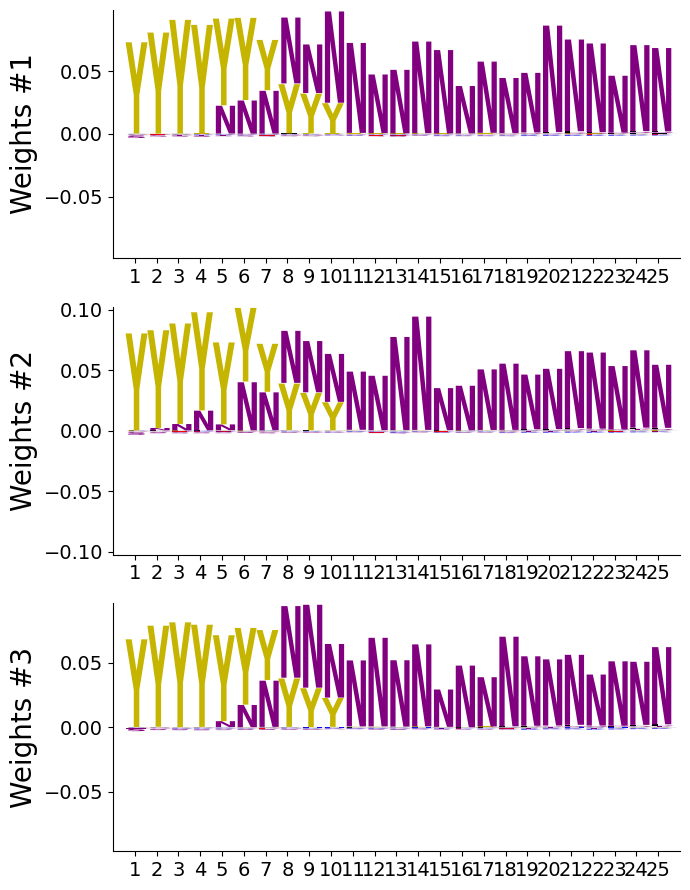

In [ ]:
num_filters_vis = 5
# print(f"Showing visualization for {num_filters_vis} of basic model")
# visualize_weights(model_1.get_weights(), 5)

print(f"Showing visualization for {num_filters_vis} of advanced model")
visualize_weights(model_2.get_weights(), 3)

## Running CNNs on Dataset 2

In [ ]:
d2_X_train, d2_X_validation, d2_X_test, d2_y_train, d2_y_validation, d2_y_test, d2_max_length = prep_data_for_model(data_csv='drive/MyDrive/sadna/data/df_CNN_Clustered.csv')
d2_X_train_one_hot_sequences = one_hot_encode(d2_X_train.values, d2_max_length)
d2_X_val_one_hot_sequences = one_hot_encode(d2_X_validation.values, d2_max_length)
d2_X_test_one_hot_sequences = one_hot_encode(d2_X_test.values, d2_max_length)
d2_model_1, d2_accuracy_1, d2_loss_1 = run_CNN(d2_X_train_one_hot_sequences, d2_y_train, d2_X_val_one_hot_sequences, d2_y_validation, d2_X_test_one_hot_sequences, d2_y_test, basic=True)
d2_model_1.save("drive/MyDrive/sadna/data/d2_model_1.h5")
d2_model_2, d2_accuracy_2, d2_loss_2 = run_CNN(d2_X_train_one_hot_sequences, d2_y_train, d2_X_val_one_hot_sequences, d2_y_validation, d2_X_test_one_hot_sequences, d2_y_test, basic=False)
d2_model_2.save("drive/MyDrive/sadna/data/d2_model_2.h5")

d2_res_df = pd.DataFrame({"model": ["basic CNN", "advanced CNN"], "accuracy": [d2_accuracy_1, d2_accuracy_2], "loss": [d2_loss_1, d2_loss_2]})
print(d2_res_df)
print()



Epoch 1/100
183/183 [==============================] - 3s 12ms/step - loss: 0.6950 - accuracy: 0.4570 - val_loss: 0.6962 - val_accuracy: 0.4283
Epoch 2/100
183/183 [==============================] - 1s 8ms/step - loss: 0.6914 - accuracy: 0.5731 - val_loss: 0.6925 - val_accuracy: 0.5502
Epoch 3/100
183/183 [==============================] - 1s 7ms/step - loss: 0.6881 - accuracy: 0.6547 - val_loss: 0.6892 - val_accuracy: 0.6168
Epoch 4/100
183/183 [==============================] - 1s 6ms/step - loss: 0.6850 - accuracy: 0.6919 - val_loss: 0.6861 - val_accuracy: 0.6516
Epoch 5/100
183/183 [==============================] - 1s 6ms/step - loss: 0.6821 - accuracy: 0.7077 - val_loss: 0.6832 - val_accuracy: 0.6783
Epoch 6/100
183/183 [==============================] - 1s 7ms/step - loss: 0.6794 - accuracy: 0.6954 - val_loss: 0.6805 - val_accuracy: 0.6824
Epoch 7/100
183/183 [==============================] - 1s 6ms/step - loss: 0.6769 - accuracy: 0.6902 - val_loss: 0.6779 - val_accuracy: 0.685

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
183/183 [==============================] - 5s 24ms/step - loss: 1.7017 - accuracy: 0.7520 - val_loss: 1.0104 - val_accuracy: 0.7490
Epoch 2/100
183/183 [==============================] - 3s 16ms/step - loss: 0.7421 - accuracy: 0.7746 - val_loss: 0.6422 - val_accuracy: 0.7275
Epoch 3/100
183/183 [==============================] - 3s 17ms/step - loss: 0.6219 - accuracy: 0.7394 - val_loss: 0.6142 - val_accuracy: 0.7254
Epoch 4/100
183/183 [==============================] - 4s 23ms/step - loss: 0.5976 - accuracy: 0.7394 - val_loss: 0.5955 - val_accuracy: 0.7254
Epoch 5/100
183/183 [==============================] - 3s 17ms/step - loss: 0.5808 - accuracy: 0.7428 - val_loss: 0.5824 - val_accuracy: 0.7264
Epoch 6/100
183/183 [==============================] - 3s 17ms/step - loss: 0.5695 - accuracy: 0.7449 - val_loss: 0.5733 - val_accuracy: 0.7316
Epoch 7/100
183/183 [==============================] - 3s 17ms/step - loss: 0.5632 - accuracy: 0.7503 - val_loss: 0.5679 - val_accuracy:

In [ ]:
d2_model_1.get_weights()[0]

array([[-0.35975382],
       [ 0.7833871 ],
       [ 0.39295733],
       [-0.41043767],
       [-0.21045773],
       [-0.38378787],
       [ 0.5056314 ],
       [ 0.14931788],
       [-0.03944173],
       [ 1.1294806 ],
       [ 0.38759783],
       [ 0.15755282],
       [-0.63082576],
       [-0.27148762],
       [-0.3845448 ],
       [-0.09872326],
       [-0.0389981 ],
       [-0.51873887],
       [ 0.6094101 ],
       [ 0.64788675]], dtype=float32)

Showing visualization for 5 of advanced model


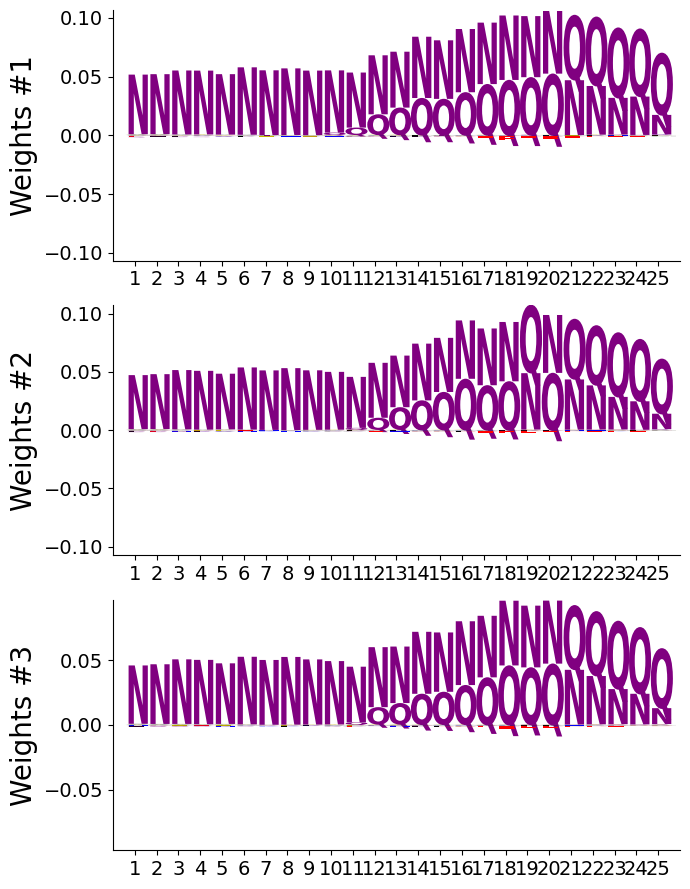

In [ ]:
num_filters_vis = 5
# print(f"Showing visualization for {num_filters_vis} of basic model")
# visualize_weights(model_1.get_weights(), 5)

print(f"Showing visualization for {num_filters_vis} of advanced model")
visualize_weights(d2_model_2.get_weights(), 3)

## Model Confusion Matrices

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from keras.models import load_model

# load models
model_disordered_no_conv = load_model("drive/MyDrive/sadna/data/model_1.h5")
model_disordered_with_conv = load_model("drive/MyDrive/sadna/data/model_2.h5")
model_all_protien_no_conv = load_model("drive/MyDrive/sadna/data/d2_model_1.h5")
model_all_protien_with_conv = load_model("drive/MyDrive/sadna/data/d2_model_2.h5")

# get test
X_train, X_validation, X_test, y_train, y_validation, y_test, max_length = prep_data_for_model(data_csv='drive/MyDrive/sadna/data/df_CNN_Clustered_old.csv')
X_test_one_hot_sequences = one_hot_encode(X_test.values, max_length)

d2_X_train, d2_X_validation, d2_X_test, d2_y_train, d2_y_validation, d2_y_test, d2_max_length = prep_data_for_model(data_csv='drive/MyDrive/sadna/data/df_CNN_Clustered.csv')
d2_X_test_one_hot_sequences = one_hot_encode(d2_X_test.values, d2_max_length)

# Predict on the test set
y_pred_1 = model_disordered_no_conv.predict(X_test_one_hot_sequences)
y_pred_2 = model_disordered_with_conv.predict(X_test_one_hot_sequences)
y_pred_3 = model_all_protien_no_conv.predict(d2_X_test_one_hot_sequences)
y_pred_4 = model_all_protien_with_conv.predict(d2_X_test_one_hot_sequences)

# Convert predictions to binary classes (thresholding at 0.5 for sigmoid activation)
y_pred_1 = y_pred_1 > 0.5
y_pred_2 = y_pred_2 > 0.5
y_pred_3 = y_pred_3 > 0.5
y_pred_4 = y_pred_4 > 0.5

# Calculate confusion matrix
cm1 = confusion_matrix(y_test, y_pred_1)
cm2 = confusion_matrix(y_test, y_pred_2)
cm3 = confusion_matrix(d2_y_test, y_pred_3)
cm4 = confusion_matrix(d2_y_test, y_pred_4)

# Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

# disp = ConfusionMatrixDisplay(cm1, display_labels=['Disordered','Prion'])

# disp.plot()
# plt.show()


32/32 [==============================] - 1s 23ms/step


In [8]:
# Assuming cm is your confusion matrix in the form of a numpy array or list
def get_cm_rates(cm):
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Calculate TPR (Sensitivity or Recall)
    TPR = TP / (TP + FN)

    # Calculate FPR
    FPR = FP / (FP + TN)

    # Calculate TNR (Specificity)
    TNR = TN / (TN + FP)

    # Calculate FNR
    FNR = FN / (FN + TP)

    # Print the results
    print("True Positive Rate (TPR):", round(TPR, 3))
    print("False Positive Rate (FPR):", round(FPR, 3))
    print("True Negative Rate (TNR):", round(TNR, 3))
    print("False Negative Rate (FNR):", round(FNR, 3))

get_cm_rates(cm1)
print("")
get_cm_rates(cm2)
print("")
get_cm_rates(cm3)
print("")
get_cm_rates(cm4)


True Positive Rate (TPR): 0.69
False Positive Rate (FPR): 0.187
True Negative Rate (TNR): 0.813
False Negative Rate (FNR): 0.31

True Positive Rate (TPR): 0.655
False Positive Rate (FPR): 0.114
True Negative Rate (TNR): 0.886
False Negative Rate (FNR): 0.345

True Positive Rate (TPR): 0.0
False Positive Rate (FPR): 0.0
True Negative Rate (TNR): 1.0
False Negative Rate (FNR): 1.0

True Positive Rate (TPR): 0.649
False Positive Rate (FPR): 0.036
True Negative Rate (TNR): 0.964
False Negative Rate (FNR): 0.351


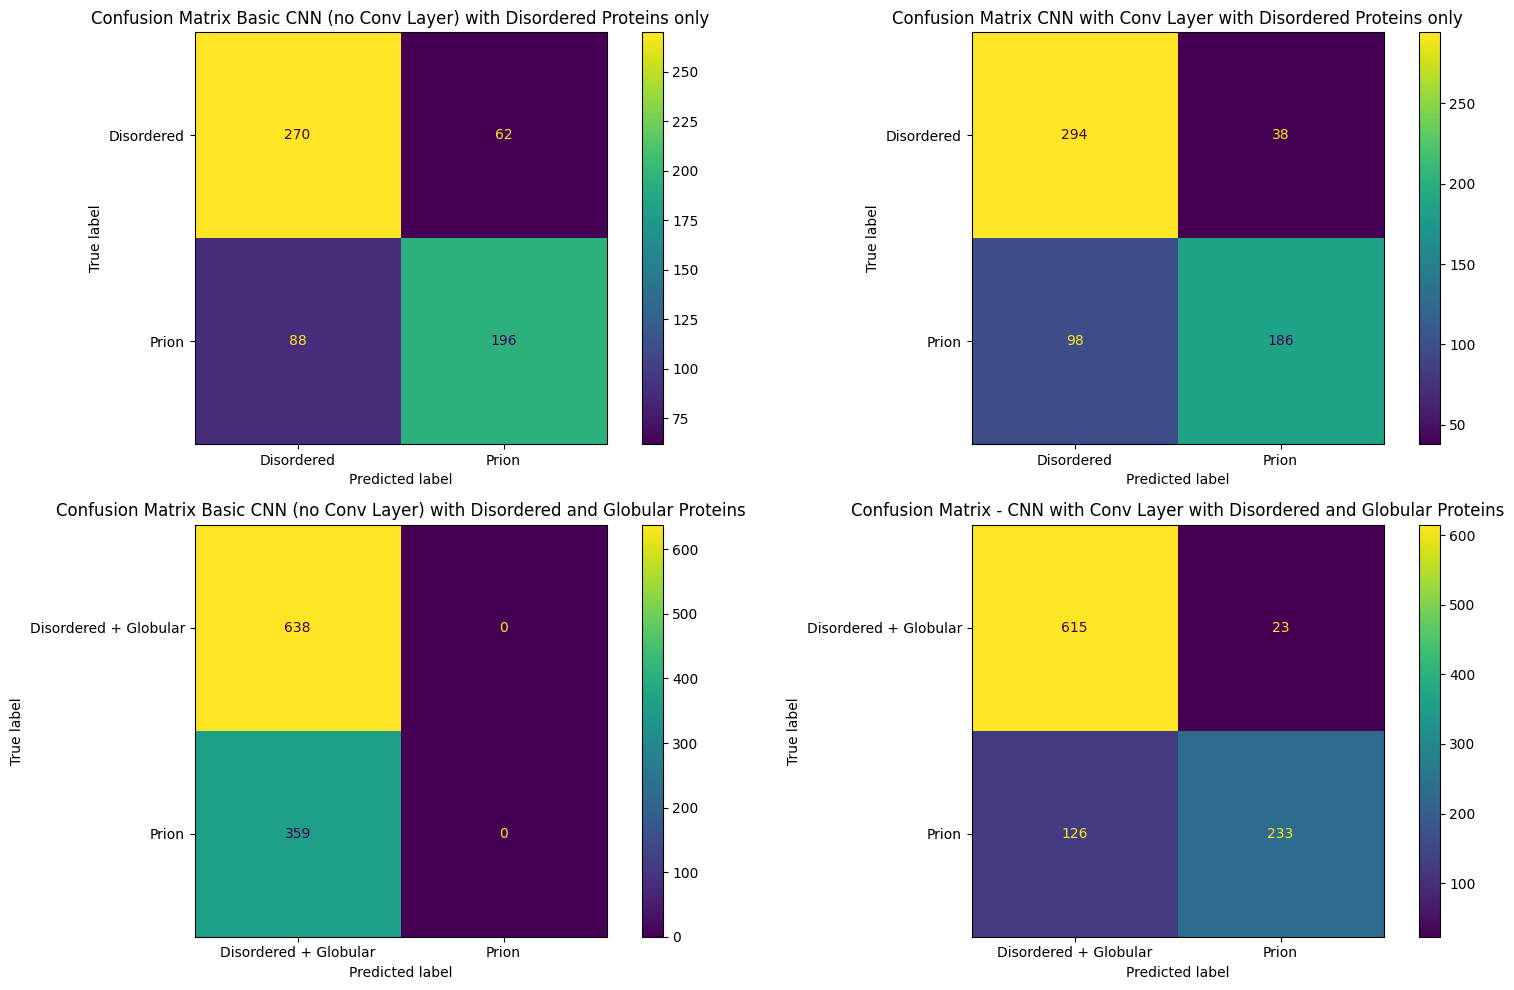

In [ ]:

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot the first confusion matrix
disp1 = ConfusionMatrixDisplay(cm1, display_labels=['Disordered', 'Prion'])
disp1.plot(ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix Basic CNN (no Conv Layer) with Disordered Proteins only')

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(cm2, display_labels=['Disordered', 'Prion'])
disp2.plot(ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix CNN with Conv Layer with Disordered Proteins only')

# Plot the third confusion matrix
disp3 = ConfusionMatrixDisplay(cm3, display_labels=['Disordered + Globular', 'Prion'])
disp3.plot(ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix Basic CNN (no Conv Layer) with Disordered and Globular Proteins')

disp3 = ConfusionMatrixDisplay(cm4, display_labels=['Disordered + Globular', 'Prion'])
disp3.plot(ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - CNN with Conv Layer with Disordered and Globular Proteins')


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Check CNN on Genomes

### General Funcs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_human_genome_one_hot_encoded(human_genome):
    human_genes = human_genome[0]
    hg_df = pd.DataFrame({"genes": human_genes})
    print(hg_df.shape)
    hg_df = hg_df[hg_df["genes"].str.len() <= 500] # Todo: change to max_length to see other results
    hg_df = hg_df.drop_duplicates()
    hg_df = hg_df[~hg_df['genes'].str.contains('[*#UXBZ]')]
    human_genes_ohe = one_hot_encode(hg_df["genes"].values, 500) # Todo: change to max_length to see other results
    return human_genes_ohe, hg_df

def plot_histogram(df, col_name, model_name):
    plt.hist(df[col_name], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Counts')
    plt.title(f'Probability Histogram For {model_name}')
    plt.show()


# Todo: deal with prions that are in train
human_prion_1 = "MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG"
human_prion_2 = "MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQITEAQVAENRPGAFIKQGRKLDIDFGAEGNRYYEANYWQFPDGIHYNGCSEANVTKEAFVTGCINATQAANQGEFQKPDNKLHQQVLWRLVQELCSLKHCEFWLERGAGLRVTMHQPVLLCLLALIWLTVK"
human_prion_3 = "MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGASRVRVRPAQRYGAPGSSLRVAAAGAAAGAAAGAAAGLAAGSGWRRAAGPGERGLEDEEDGVPGGNGTGPGIYSYRAWTSGAGPTRGPRLCLVLGGALGALGLLRP"
human_prion_4 = "MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAAPWWWLGTASWWWLGSRRWHPQSVEQAE"
human_prion_5 = "MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTTLPHTAWPLSFLHQTVSTLKAVAVTHSLWHLQIPVDCQACNRKSKKIYC"
human_prions = [human_prion_1, human_prion_2, human_prion_3, human_prion_4, human_prion_5]

def sequence_rank(df, col_name, sequence):
    # Sort the DataFrame by probability in descending order
    df_sorted = df.sort_values(by=col_name, ascending=False).reset_index(drop=True)

    # find the index (rank) of the given sequence
    try:
        rank = df_sorted[df_sorted['genes'] == sequence].index[0] + 1
        return rank
    except IndexError:
        return f"Sequence '{sequence}' not found in the DataFrame."


def get_ranks(hg_df, col_name):
    print('rank for human prion 1 -' , str(sequence_rank(hg_df, col_name, human_prion_1)))
    print('rank for human prion 2 -' , str(sequence_rank(hg_df, col_name, human_prion_2)))
    print('rank for human prion 3 -' , str(sequence_rank(hg_df, col_name, human_prion_3)))
    print('rank for human prion 4 -' , str(sequence_rank(hg_df, col_name, human_prion_4)))
    print('rank for human prion 5 -' , str(sequence_rank(hg_df, col_name, human_prion_5)))


### Human Genome

In [ ]:
human_genome = load_FASTA("drive/MyDrive/sadna/data/uniprotkb_proteome_UP000005640_AND_revi_2024_02_28.fasta")

In [ ]:
from keras.models import load_model
model_disordered_no_conv = load_model("drive/MyDrive/sadna/data/model_1.h5")
model_disordered_with_conv = load_model("drive/MyDrive/sadna/data/model_2.h5")
model_all_protien_no_convo =load_model("drive/MyDrive/sadna/data/d2_model_1.h5")
model_all_protien_with_convo=load_model("drive/MyDrive/sadna/data/d2_model_2.h5")

In [ ]:
human_genes_ohe, human_genes_df = get_human_genome_one_hot_encoded(human_genome)
pred_1 = model_disordered_no_conv.predict(human_genes_ohe)
pred_2 = model_disordered_with_conv.predict(human_genes_ohe)
d2_pred_1 = model_all_protien_no_convo.predict(human_genes_ohe)
d2_pred_2 = model_all_protien_with_convo.predict(human_genes_ohe)

(20418, 1)
384/384 [==============================] - 42s 108ms/step


In [ ]:
human_genes_df.loc[:, ["model_1_pred", "model_2_pred", "d2_model_1_pred", "d2_model_2_pred"]] = pred_1, pred_2, d2_pred_1, d2_pred_2


<ipython-input-6-7a85ad98aea3>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  human_genes_df.loc[:, ["model_1_pred", "model_2_pred", "d2_model_1_pred", "d2_model_2_pred"]] = pred_1, pred_2, d2_pred_1, d2_pred_2


In [ ]:
human_genes_df[human_genes_df["genes"].isin(human_prions)]

,genes,model_1_pred,model_2_pred,d2_model_1_pred,d2_model_2_pred
2032,MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGG...,0.539081,0.888120,0.339745,0.503626
13593,MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQI...,0.507200,0.627681,0.364502,0.459440
15038,MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGA...,0.454865,0.155283,0.338311,0.079279
16818,MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAA...,0.455151,0.075199,0.358389,0.068900
19619,MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTT...,0.529354,0.142028,0.360302,0.102102


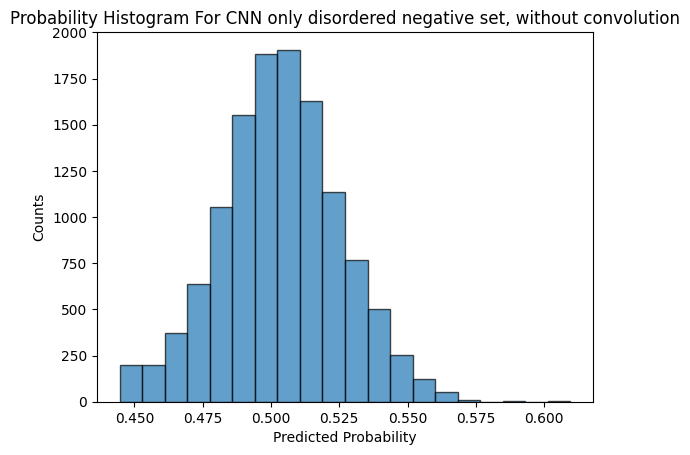

rank for human prion 1 - 665
rank for human prion 2 - 5203
rank for human prion 3 - 12052
rank for human prion 4 - 12041
rank for human prion 5 - 1462


In [ ]:
plot_histogram(human_genes_df, "model_1_pred", "CNN only disordered negative set, without convolution")
get_ranks(human_genes_df, "model_1_pred")

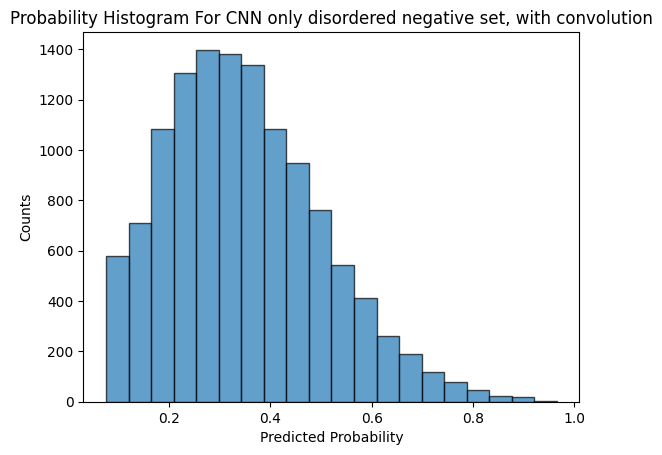

rank for human prion 1 - 12
rank for human prion 2 - 630
rank for human prion 3 - 11114
rank for human prion 4 - 12265
rank for human prion 5 - 11387


In [ ]:
plot_histogram(human_genes_df, "model_2_pred", "CNN only disordered negative set, with convolution")
get_ranks(human_genes_df, "model_2_pred")

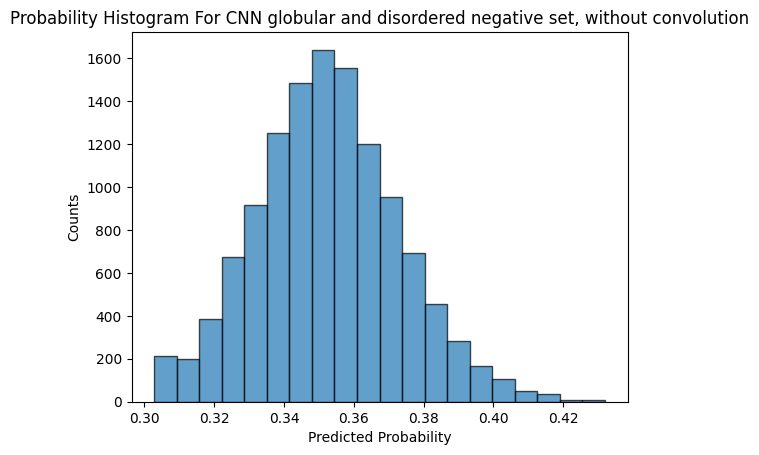

rank for human prion 1 - 8993
rank for human prion 2 - 3277
rank for human prion 3 - 9279
rank for human prion 4 - 4533
rank for human prion 5 - 4103


In [ ]:
plot_histogram(human_genes_df, "d2_model_1_pred", "CNN globular and disordered negative set, without convolution")
get_ranks(human_genes_df, "d2_model_1_pred")

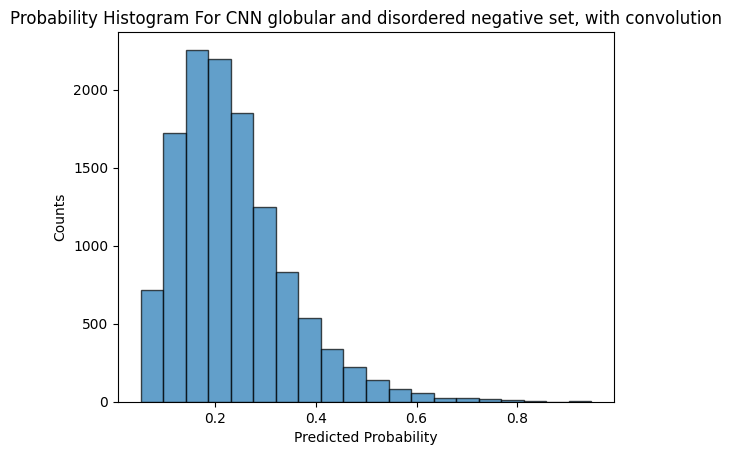

rank for human prion 1 - 350
rank for human prion 2 - 556
rank for human prion 3 - 11984
rank for human prion 4 - 12108
rank for human prion 5 - 11477


In [ ]:
plot_histogram(human_genes_df, "d2_model_2_pred", "CNN globular and disordered negative set, with convolution")
get_ranks(human_genes_df, "d2_model_2_pred")

In [ ]:
from keras.models import load_model

# load human genome data
human_genome = load_FASTA("drive/MyDrive/sadna/data/uniprotkb_proteome_UP000005640_AND_revi_2024_02_28.fasta")
human_genes_ohe, human_genes_df = get_human_genome_one_hot_encoded(human_genome)

# CNN conv models
model_2 = load_model("drive/MyDrive/sadna/data/model_2.h5")
d2_model_2 = load_model("drive/MyDrive/sadna/data/d2_model_2.h5")

# pred model_2 and rank
p2 = model_2.predict(human_genes_ohe)
human_genes_df["pred_2"] = p2
df_sorted = human_genes_df.sort_values(by="pred_2", ascending=False).reset_index(drop=True)
print(df_sorted.head())

# pred d2_model_2 and rank
d2_p2 = d2_model_2.predict(human_genes_ohe)
human_genes_df["d2_pred_2"] = d2_p2
d2_df_sorted = human_genes_df.sort_values(by="d2_pred_2", ascending=False).reset_index(drop=True)
print(d2_df_sorted.head())


(20418, 1)
384/384 [==============================] - 36s 94ms/step
                                               genes    pred_2
0  MKFTIVFAGLLGVFLAPALANYNINVNDDNNNAGSGQQSVSVNNEH...  0.965796
1  MEKTLETVPLERKKREKEQFRKLFIGGLSFETTEESLRNYYEQWGK...  0.948761
2  MPAENSPAPAYKVSSHGGDSGLDGLGGPGVQLGSPDKKKRKANTQG...  0.939643
3  MTCVEQDKLGQAFEDAFEVLRQHSTGDLQYSPDYRNYLALINHRPH...  0.923564
4  MNWHMIISGLIVVVLKVVGMTLFLLYFPQIFNKSNDGFTTTRSYGT...  0.910259
384/384 [==============================] - 35s 91ms/step
                                               genes    pred_2  d2_pred_2
0  MDQNNSLPPYAQGLASPQGAMTPGIPIFSPMMPYGTGLTPQPIQNT...  0.289791   0.947320
1  MQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...  0.075199   0.936216
2  MKFTIVFAGLLGVFLAPALANYNINVNDDNNNAGSGQQSVSVNNEH...  0.965796   0.920569
3  MPAENSPAPAYKVSSHGGDSGLDGLGGPGVQLGSPDKKKRKANTQG...  0.939643   0.903039
4  MPGFTCCVPGCYNNSHRDKALHFYTFPKDAELRRLWLKNVSRAGVS...  0.248182   0.894109


In [ ]:
both_sorted = human_genes_df.sort_values(by=['pred_2', 'd2_pred_2'], ascending=False).reset_index(drop=True)
both_sorted.head()


,genes,pred_2,d2_pred_2
0,MKFTIVFAGLLGVFLAPALANYNINVNDDNNNAGSGQQSVSVNNEH...,0.965796,0.920569
1,MEKTLETVPLERKKREKEQFRKLFIGGLSFETTEESLRNYYEQWGK...,0.948761,0.735900
2,MPAENSPAPAYKVSSHGGDSGLDGLGGPGVQLGSPDKKKRKANTQG...,0.939643,0.903039
3,MTCVEQDKLGQAFEDAFEVLRQHSTGDLQYSPDYRNYLALINHRPH...,0.923564,0.632419
4,MNWHMIISGLIVVVLKVVGMTLFLLYFPQIFNKSNDGFTTTRSYGT...,0.910259,0.790942


Number of proteins classified as prions in CNN d1 2044
Percent of human genome classified as prions: 16.6%
Number of proteins classified as prions in CNN d2 364
Percent of human genome classified as prions: 3.0%


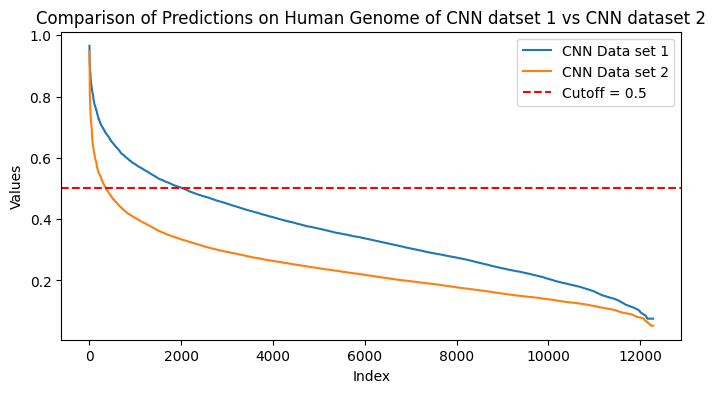

In [ ]:
from matplotlib import pyplot as plt

# Sort the first DataFrame by 'pred_2' column
pred_2_sorted = human_genes_df.sort_values(by='pred_2', ascending=False).reset_index(drop=True)
print(f"Number of proteins classified as prions in CNN d1 {len(pred_2_sorted[pred_2_sorted['pred_2'] > 0.5])}")
print(f"Percent of human genome classified as prions: {round(len(pred_2_sorted[pred_2_sorted['pred_2'] > 0.5]) / len(pred_2_sorted), 3) * 100}%")

# Sort the second DataFrame by 'd2_pred_2' column
d2_pred_2_sorted = human_genes_df.sort_values(by='d2_pred_2', ascending=False).reset_index(drop=True)
print(f"Number of proteins classified as prions in CNN d2 {len(d2_pred_2_sorted[d2_pred_2_sorted['d2_pred_2'] > 0.5])}")
print(f"Percent of human genome classified as prions: {round(len(d2_pred_2_sorted[d2_pred_2_sorted['d2_pred_2'] > 0.5]) / len(d2_pred_2_sorted), 3) * 100}%")

# Create figure and plot the first DataFrame
plt.figure(figsize=(8, 4))
plt.plot(pred_2_sorted['pred_2'], label='CNN Data set 1')

# Plot the second DataFrame on the same graph
plt.plot(d2_pred_2_sorted['d2_pred_2'], label='CNN Data set 2')

# Add red line at cutoff threshold of 0.5
plt.axhline(y=0.5, color='red', linestyle='--', label='Cutoff = 0.5')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Predictions on Human Genome of CNN datset 1 vs CNN dataset 2')
plt.legend()

# Show plot
plt.show()


### Arabidopsis Thaliana Genome

In [ ]:
from keras.models import load_model

# load human genome data
at_genome = load_FASTA("drive/MyDrive/sadna/data/UP000006548_3702.fasta")
at_genes_ohe, at_genes_df = get_human_genome_one_hot_encoded(at_genome)

# CNN conv models
model_2 = load_model("drive/MyDrive/sadna/data/model_2.h5")
d2_model_2 = load_model("drive/MyDrive/sadna/data/d2_model_2.h5")

# pred model_2 and rank
at_p2 = model_2.predict(at_genes_ohe)
at_genes_df["pred_2"] = at_p2
at_df_sorted = at_genes_df.sort_values(by="pred_2", ascending=False).reset_index(drop=True)
print(at_df_sorted.head())

# pred d2_model_2 and rank
at_d2_p2 = d2_model_2.predict(at_genes_ohe)
at_genes_df["d2_pred_2"] = at_d2_p2
at_d2_df_sorted = at_genes_df.sort_values(by="d2_pred_2", ascending=False).reset_index(drop=True)
print(at_d2_df_sorted.head())


(27448, 1)
622/622 [==============================] - 58s 93ms/step
                                               genes    pred_2
0  MFVNFKYFSFFIRTKMDGVTGGGTNIGEAVTAPPPRNPHPATLLNA...  0.999572
1  MEITQYQSFHEGSSSRVSMNRNSQVISKIKPKIRIIHIFAPEVIKT...  0.998876
2  MEEYQHDNSTTPQRVSFLYSPISSSNKNDNTSDTNNNNNNNNSSNY...  0.996187
3  MEMGSNSGPGHGPGQAESGGSSTESSSFSGGLMFGQKIYFEDGGGG...  0.995553
4  MASSSELSLDCKPQSYSMLLKSFGDNFQSDPTTHKLEDLLSRLEQE...  0.994912
622/622 [==============================] - 58s 93ms/step
                                               genes    pred_2  d2_pred_2
0  MFVNFKYFSFFIRTKMDGVTGGGTNIGEAVTAPPPRNPHPATLLNA...  0.999572   0.997583
1  MEITQYQSFHEGSSSRVSMNRNSQVISKIKPKIRIIHIFAPEVIKT...  0.998876   0.994956
2  MEMGSNSGPGHGPGQAESGGSSTESSSFSGGLMFGQKIYFEDGGGG...  0.995553   0.985229
3  MEEYQHDNSTTPQRVSFLYSPISSSNKNDNTSDTNNNNNNNNSSNY...  0.996187   0.984406
4  MASSSELSLDCKPQSYSMLLKSFGDNFQSDPTTHKLEDLLSRLEQE...  0.994912   0.982541


Number of proteins classified as prions in CNN d1 4990
Percent of Arabidopsis genome classified as prions: 25.1%
Number of proteins classified as prions in CNN d2 1324
Percent of Arabidopsis genome classified as prions: 6.7%


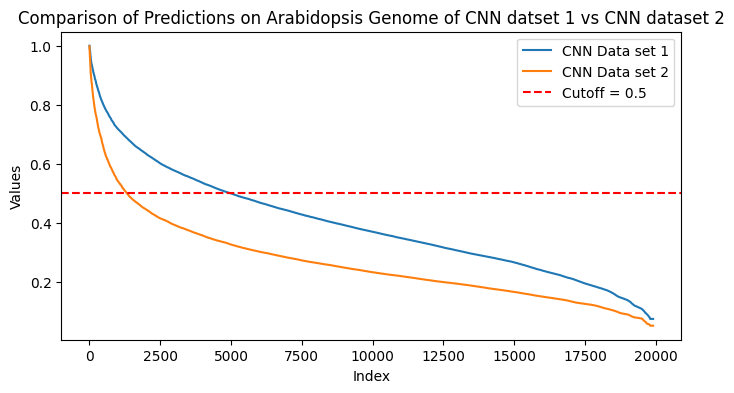

In [ ]:
from matplotlib import pyplot as plt

# Sort the first DataFrame by 'pred_2' column
at_pred_2_sorted = at_genes_df.sort_values(by='pred_2', ascending=False).reset_index(drop=True)
print(f"Number of proteins classified as prions in CNN d1 {len(at_pred_2_sorted[at_pred_2_sorted['pred_2'] > 0.5])}")
print(f"Percent of Arabidopsis genome classified as prions: {round(len(at_pred_2_sorted[at_pred_2_sorted['pred_2'] > 0.5]) / len(at_pred_2_sorted), 3) * 100}%")

# Sort the second DataFrame by 'd2_pred_2' column
at_d2_pred_2_sorted = at_genes_df.sort_values(by='d2_pred_2', ascending=False).reset_index(drop=True)
print(f"Number of proteins classified as prions in CNN d2 {len(at_d2_pred_2_sorted[at_d2_pred_2_sorted['d2_pred_2'] > 0.5])}")
print(f"Percent of Arabidopsis genome classified as prions: {round(len(at_d2_pred_2_sorted[at_d2_pred_2_sorted['d2_pred_2'] > 0.5]) / len(at_d2_pred_2_sorted), 3) * 100}%")

# Create figure and plot the first DataFrame
plt.figure(figsize=(8, 4))
plt.plot(at_pred_2_sorted['pred_2'], label='CNN Data set 1')

# Plot the second DataFrame on the same graph
plt.plot(at_d2_pred_2_sorted['d2_pred_2'], label='CNN Data set 2')

# Add red line at cutoff threshold of 0.5
plt.axhline(y=0.5, color='red', linestyle='--', label='Cutoff = 0.5')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Predictions on Arabidopsis Genome of CNN datset 1 vs CNN dataset 2')
plt.legend()

# Show plot
plt.show()


# Old CNN Runs (no funcs)

### Split Data

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

#Sperate data for test
df_CNN = pd.read_csv('drive/MyDrive/sadna/data/df_CNN_Clustered.csv')
X_matrix = df_CNN['Sequence']
y_vector = df_CNN['Prion?']
components_groups = df_CNN['Component']
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) # 5 non-overlapping tests, meaning around 20% test - 80% train each
sgkf_split = sgkf.split(X_matrix, y_vector, components_groups) # splits while stratifying y and keeping same components together

data_split = [[train_index, test_index] for i, (train_index, test_index) in enumerate(sgkf_split)]
train_index, test_index = data_split[0]

X_train, X_test = X_matrix.loc[train_index], X_matrix.loc[test_index]
y_train, y_test = y_vector[train_index], y_vector[test_index]

#Sperate data for eval
df_validation = df_CNN.loc[train_index]
df_validation = df_validation.reset_index()
X_matrix = df_validation['Sequence']
y_vector = df_validation['Prion?']
components_groups = df_validation['Component']
sgkf = StratifiedGroupKFold(n_splits=4) # 4 non-overlapping tests, meaning around 20% eval - 60% train each
sgkf_split = sgkf.split(X_matrix, y_vector, components_groups) # splits while stratifying y and keeping same components together
data_split = [[train_index, validation_index] for i, (train_index, validation_index) in enumerate(sgkf_split)]
train_index, validation_index = data_split[0]

X_train, X_validation = X_matrix.loc[train_index], X_matrix.loc[validation_index]
y_train, y_validation = y_vector[train_index], y_vector[validation_index]




### One_Hot_Encode X_data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D, Masking
from keras.utils import to_categorical


# Convert sequences to one-hot encoding + Padd To Max Seq
def one_hot_encode(sequences, max_length):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # List of all possible amino acids
    one_hot_dict = {aa: [1 if aa == base else 0 for base in amino_acids] for aa in amino_acids}
    one_hot_sequences = []
    for seq in sequences:
      seq_array = []
      for aa in seq:
        seq_array.append(one_hot_dict[aa])
      seq_array.extend([[0]*20]*(max_length-len(seq)))
      one_hot_sequences.append(np.array(seq_array))
    one_hot_sequences = np.array(one_hot_sequences)
    return one_hot_sequences


# One-hot encode sequences
max_length = df_CNN['Sequence'].str.len().max()
X_train_one_hot_sequences = one_hot_encode(X_train.values, max_length)
X_val_one_hot_sequences = one_hot_encode(X_validation.values, max_length)
X_test_one_hot_sequences = one_hot_encode(X_test.values, max_length)


### First basic CNN (similar to logistic regression)

#### Basic model (no conv layer)

In [ ]:
# Build the CNN model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 20)))  # Masking layer for variable length sequences
model.add(AveragePooling1D(pool_size=30, strides=1))
model.add(Dense(1, activation='sigmoid'))
# model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(GlobalMaxPooling1D())


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=10, batch_size=16, validation_data=(X_val_one_hot_sequences, y_validation.values.astype(int)))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

Epoch 1/10
187/187 [==============================] - 17s 20ms/step - loss: 0.6811 - accuracy: 0.6554 - val_loss: 0.6688 - val_accuracy: 0.6677
Epoch 2/10
187/187 [==============================] - 2s 10ms/step - loss: 0.6607 - accuracy: 0.6681 - val_loss: 0.6507 - val_accuracy: 0.6627
Epoch 3/10
187/187 [==============================] - 2s 10ms/step - loss: 0.6462 - accuracy: 0.6631 - val_loss: 0.6367 - val_accuracy: 0.6637
Epoch 4/10
187/187 [==============================] - 1s 8ms/step - loss: 0.6345 - accuracy: 0.6634 - val_loss: 0.6248 - val_accuracy: 0.6637
Epoch 5/10
187/187 [==============================] - 2s 11ms/step - loss: 0.6238 - accuracy: 0.6638 - val_loss: 0.6135 - val_accuracy: 0.6637
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.6139 - accuracy: 0.6641 - val_loss: 0.6030 - val_accuracy: 0.6657
Epoch 7/10
187/187 [==============================] - 2s 8ms/step - loss: 0.6045 - accuracy: 0.6698 - val_loss: 0.5931 - val_accuracy: 0.6667
E

#### Less Basic (1 conv layer)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
from keras.optimizers import Adam


# # Split the data (60% train, 20% validation, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.4, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Build the CNN model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 20)))  # Masking layer for variable length sequences
model.add(Conv1D(filters=256, kernel_size=25, activation='relu', kernel_regularizer=l1(0.001))) #change params
model.add(AveragePooling1D(pool_size=30, strides=1))
model.add(Dense(1, activation='sigmoid'))
model.add(GlobalMaxPooling1D())

# Change Learning Rate
opt = Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model
model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=100, batch_size=16, validation_data=(X_val_one_hot_sequences, y_validation.values.astype(int)), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

Epoch 1/100
187/187 [==============================] - 6s 29ms/step - loss: 1.6747 - accuracy: 0.7463 - val_loss: 0.9785 - val_accuracy: 0.8258
Epoch 2/100
187/187 [==============================] - 3s 17ms/step - loss: 0.7306 - accuracy: 0.7731 - val_loss: 0.6343 - val_accuracy: 0.7207
Epoch 3/100
187/187 [==============================] - 3s 17ms/step - loss: 0.6200 - accuracy: 0.7313 - val_loss: 0.6131 - val_accuracy: 0.7137
Epoch 4/100
187/187 [==============================] - 3s 17ms/step - loss: 0.5982 - accuracy: 0.7356 - val_loss: 0.5977 - val_accuracy: 0.7157
Epoch 5/100
187/187 [==============================] - 4s 19ms/step - loss: 0.5847 - accuracy: 0.7383 - val_loss: 0.5882 - val_accuracy: 0.7187
Epoch 6/100
187/187 [==============================] - 3s 17ms/step - loss: 0.5754 - accuracy: 0.7400 - val_loss: 0.5838 - val_accuracy: 0.7207
Epoch 7/100
187/187 [==============================] - 3s 17ms/step - loss: 0.5699 - accuracy: 0.7426 - val_loss: 0.5793 - val_accuracy:

#### Weights

In [ ]:
weights = model.get_weights()

In [ ]:
weights[0]

array([[[-7.57206290e-05, -6.42298255e-04,  1.03193059e-04, ...,
         -1.35440473e-03, -1.01601810e-03, -2.39614281e-04],
        [ 9.94869333e-06,  6.91078458e-05, -2.42862254e-04, ...,
         -6.21638974e-05, -4.83368494e-05,  3.32438212e-05],
        [-1.23768914e-05,  1.32894493e-04,  3.86245811e-05, ...,
          1.02070029e-04, -4.92629362e-04,  6.12228614e-05],
        ...,
        [ 1.03061670e-04,  5.36164385e-04,  1.50470354e-04, ...,
          9.97475727e-05, -1.57329196e-04, -1.78390430e-04],
        [ 1.81441501e-04, -2.79018626e-04, -2.46843265e-05, ...,
          3.96778851e-05, -5.67888375e-04, -5.00954920e-05],
        [ 1.77142298e-04,  1.69848907e-04, -9.37231016e-05, ...,
          5.46091702e-04,  7.76252476e-04, -1.17666059e-05]],

       [[-1.27803520e-04, -1.30959472e-03,  3.75087984e-05, ...,
         -1.28189893e-03, -1.14816148e-03,  6.95673443e-05],
        [-1.42221586e-04,  3.43813968e-04, -3.82825558e-04, ...,
          6.07897819e-05,  2.81552871e

#### Jerome's logo code


In [ ]:
"""
 Copyright 2020 - by Jerome Tubiana (jertubiana@gmail.com)
     All rights reserved

     Permission is granted for anyone to copy, use, or modify this
     software for any uncommercial purposes, provided this copyright
     notice is retained, and note is made of any changes that have
     been made. This software is distributed without any warranty,
     express or implied. In no event shall the author or contributors be
     liable for any damage arising out of the use of this software.

     The publication of research using this software, modified or not, must include
     appropriate citations to:
"""

import numpy as np
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import copy
import os

## Implementation inspired from https://stackoverflow.com/questions/42615527/sequence-logos-in-matplotlib-aligning-xticks
## Color choice inspired from: http://weblogo.threeplusone.com/manual.html

def get_ax(ax,i,nrows,ncols):
    if (ncols>1) & (nrows>1):
        col = i%ncols
        row = i//ncols
        ax_ = ax[row,col]
    elif (ncols>1) & (nrows==1):
        ax_ = ax[i]
    elif (ncols==1) & (nrows>1):
        ax_ = ax[i]
    else:
        ax_ = ax
    return ax_


def select_sites( W,  window = 5, theta_important = 0.25 ):
    n_sites = W.shape[0]
    norm = np.abs(W).sum(-1)
    important = np.nonzero(norm/norm.max() > theta_important)[0]
    selected = []
    for imp in important:
        selected += range( max(0,imp-window), min(imp+window+1,n_sites ) )
    selected = np.unique(selected)
    return selected

def ticksAt(selected,ticks_every=10):
    n_selected = len(selected)
    all_ticks = []
    all_ticks_labels = []
    previous_select = selected[0]
    k = 0
    for select in selected:
        if (select-previous_select)>1:
            k+=1
        if (select%ticks_every==0) | ((select-previous_select)>1):
            if not k in all_ticks:
                all_ticks.append(k+1)
                all_ticks_labels.append(select+1)
        previous_select = copy.copy(select)
        k+=1
    return np.array(all_ticks), np.array(all_ticks_labels)




def breaksAt(x,maxi_size,ax):
    ax.plot([x,x],[-maxi_size,maxi_size],linewidth=5,c='black',linestyle='--')



def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def aa_color(letter):
    if letter in ['C']:
        return 'green'
    elif letter in ['F','W','Y']:
        return [199/256., 182/256., 0.,1.]#'gold'
    elif letter in ['Q','N','S','T']:
        return 'purple'
    elif letter in ['V','L','I','M']:
        return 'black'
    elif letter in ['K','R','H']:
        return 'blue'
    elif letter in  ['D','E']:
        return 'red'
    elif letter in ['A','P','G']:
        return 'grey'
    elif letter in ['$\\boxminus$']:
        return 'black'
    else:
        return 'black'



def build_scores(matrix,epsilon = 1e-4):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    all_scores = []
    for site in range(n_sites):
        conservation = np.log2(21) + (np.log2(matrix[site]+epsilon) * matrix[site]).sum()
        liste = []
        order_colors = np.argsort(matrix[site])
        for c in order_colors:
            liste.append( (list_aa[c],matrix[site,c] * conservation) )
        all_scores.append(liste)
    return all_scores


def build_scores2(matrix):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    epsilon = 1e-4
    all_scores = []
    for site in range(n_sites):
        liste = []
        c_pos = np.nonzero(matrix[site] >= 0)[0]
        c_neg = np.nonzero(matrix[site] < 0)[0]

        order_colors_pos = c_pos[np.argsort(matrix[site][c_pos])]
        order_colors_neg = c_neg[np.argsort(-matrix[site][c_neg])]
        for c in order_colors_pos:
            liste.append( (list_aa[c],matrix[site,c],'+') )
        for c in order_colors_neg:
            liste.append( (list_aa[c],-matrix[site,c],'-') )
        all_scores.append(liste)
    return all_scores

def build_scores_break(matrix, selected,epsilon=1e-4):
    has_breaks = (selected[1:] - selected[:-1])>1
    has_breaks = np.concatenate((np.zeros(1),has_breaks) ,axis=0)
    n_sites = len(selected)
    n_colors = matrix.shape[1]

    epsilon = 1e-4
    all_scores = []
    maxi_size = 0
    for site,has_break in zip(selected,has_breaks):
        if has_break:
            all_scores.append([('BREAK','BREAK','BREAK')] )
#             all_scores.append([('BREAK','BREAK','BREAK')] )
        conservation = np.log2(21) + (np.log2(matrix[site]+epsilon) * matrix[site]).sum()
        liste = []
        order_colors = np.argsort(matrix[site])
        for c in order_colors:
            liste.append( (list_aa[c],matrix[site,c] * conservation) )
        maxi_size = max(maxi_size, conservation)
        all_scores.append(liste)
    return all_scores,maxi_size


def build_scores2_break(matrix, selected):
    has_breaks = (selected[1:] - selected[:-1])>1
    has_breaks = np.concatenate((np.zeros(1),has_breaks) ,axis=0)
    n_sites = len(selected)
    n_colors = matrix.shape[1]

    epsilon = 1e-4
    all_scores = []
    for site,has_break in zip(selected,has_breaks):
        if has_break:
            all_scores.append([('BREAK','BREAK','BREAK')] )
        liste = []
        c_pos = np.nonzero(matrix[site] >= 0)[0]
        c_neg = np.nonzero(matrix[site] < 0)[0]

        order_colors_pos = c_pos[np.argsort(matrix[site][c_pos])]
        order_colors_neg = c_neg[np.argsort(-matrix[site][c_neg])]
        for c in order_colors_pos:
            liste.append( (list_aa[c],matrix[site,c],'+') )
        for c in order_colors_neg:
            liste.append( (list_aa[c],-matrix[site,c],'-') )
        all_scores.append(liste)
    maxi_size = np.abs(matrix).sum(-1).max()
    return all_scores,maxi_size



fp = FontProperties(family="Arial", weight="bold")
globscale = 1.35
list_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W','Y','$\\boxminus$']
LETTERS = dict([ (letter, TextPath((-0.30, 0), letter, size=1, prop=fp) )   for letter in list_aa] )
COLOR_SCHEME = dict( [(letter,aa_color(letter)) for letter in list_aa] )

def Sequence_logo(matrix, ax = None,data_type=None,figsize=None,ylabel = None,title=None,epsilon=1e-4,show=True,
                  nrows=1,ticks_every=1,ticks_labels_size=14,title_size=20, x_start =0,x_stop=None):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'

    if ax is not None:
        show = False
        return_fig = False
    else:
        if figsize is None:
            figsize = (  max(int(0.3 * matrix.shape[0])/nrows, 2)  ,  3*nrows)
        fig, ax = plt.subplots(nrows,1,figsize=figsize)
        return_fig = True

    if nrows>1:
        siz = int( np.ceil(matrix.shape[0]/nrows) )
        minis = []
        maxis = []
        for row in range(nrows):
            if row < nrows-1:
                matrix_ = matrix[row*siz:(row+1)*siz]
            else:
                matrix_ = np.zeros( [siz, matrix.shape[-1] ] )
                matrix_[: len(matrix[row*siz:]) ] = matrix[row*siz:]
            if row == 0:
                ylabel_ = ylabel
                title_ = title
            else:
                ylabel_ = '...'
                title_ = ''
            Sequence_logo(matrix_,ax=ax[row], figsize = figsize, ticks_every=ticks_every,
                          ticks_labels_size=ticks_labels_size, title_size=title_size,
                          show=False, ylabel = ylabel_, title = title_,
                          data_type=data_type, x_start = row*siz,nrows=1)
            minis.append(ax[row].get_ylim()[0])
            maxis.append(ax[row].get_ylim()[1])

        for row in range(nrows):
            ax[row].set_ylim([min(minis),max(maxis)])

    else:
        if data_type == 'mean':
            all_scores = build_scores(matrix,epsilon=epsilon)
        elif data_type =='weights':
            all_scores = build_scores2(matrix)
        else:
            print('data type not understood')
            return -1

        x = 1
        maxi = 0
        mini = 0
        for scores in all_scores:
            if data_type == 'mean':
                y = 0
                for base, score in scores:
                    if score > 0.01:
                        letterAt(base, x,y, score, ax)
                    y += score
                x += 1
                maxi = max(maxi, y)


            elif data_type =='weights':
                y_pos = 0
                y_neg = 0
                for base,score,sign in scores:
                    if sign == '+':
                        letterAt(base, x,y_pos, score, ax)
                        y_pos += score
                    else:
                        y_neg += score
                        letterAt(base, x,-y_neg, score, ax)
                x += 1
                maxi = max(y_pos,maxi)
                mini = min(-y_neg,mini)

        if data_type == 'weights':
            maxi = max(  maxi, abs(mini) )
            mini = -maxi

        if ticks_every > 1:
            xticks = range(1,x)
            xtickslabels = ['%s'%(x_start+k) if (x_start+k)%ticks_every==0 else '' for k in xticks]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtickslabels)
        else:
            ax.set_xticks(range(1,x))
            ax.set_xticklabels(range(x_start+1,x_start+x))
        ax.set_xlim((0, x))
        ax.set_ylim((mini, maxi))
        if ylabel is None:
            if data_type == 'mean':
                ylabel = 'Conservation (bits)'
            elif data_type =='weights':
                ylabel = 'Weights'
        ax.set_ylabel(ylabel,fontsize=title_size)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='both', which='major', labelsize=ticks_labels_size)
        ax.tick_params(axis='both', which='minor', labelsize=ticks_labels_size)
        if title is not None:
            ax.set_title(title,fontsize=title_size)
    if return_fig:
        plt.tight_layout()
        if show:
            plt.show()
        return fig

def Sequence_logo_breaks(matrix, data_type=None,selected = None, window=5,theta_important=0.25,figsize=None,nrows=1,ylabel = None,title=None,epsilon=1e-4,show=True,ticks_every=5,ticks_labels_size=14,title_size=20):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'

    if selected is None:
        if data_type == 'mean':
            'NO SELECTION SUPPORTED FOR MEAN VECTOR'
            return
        else:
            selected = select_sites(matrix,window=window,theta_important=theta_important)
    else:
        selected = np.array(selected)
    print('Number of sites selected: %s'%len(selected))

    xticks,xticks_labels = ticksAt(selected,ticks_every=ticks_every)

    if data_type == 'mean':
        all_scores,maxi_size = build_scores_break(matrix,selected,epsilon=epsilon)
    elif data_type =='weights':
        all_scores,maxi_size = build_scores2_break(matrix,selected)
    else:
        print('data type not understood')
        return -1


    nbreaks = ( (selected[1:] - selected[:-1])>1 ).sum()
    width = (len(selected) + nbreaks)/nrows

    if figsize is None:
        figsize = (  max(int(0.3 * width), 2)  ,  3 * nrows)


    fig, ax = plt.subplots(figsize=figsize,nrows=nrows)
    if nrows>1:
        for row in range(nrows):
            ax[row].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    x = 1
    maxi = 0
    mini = 0

    if nrows>1:
        row = 0
        ax_ = ax[row]
        xmins = np.zeros(nrows)
        xmaxs = np.ones(nrows) * (len(selected) + nbreaks+1)
    else:
        ax_ = ax



    for scores in all_scores:
        if data_type == 'mean':
            y = 0
            if scores[0][0] == 'BREAK':
                breaksAt(x,maxi_size,ax_)
                if nrows>1:
                    if x> (1+row)*width:
                        xmaxs[row] = copy.copy(x)+1
                        xmins[row+1] = copy.copy(x)
                        row+=1
                        ax_ = ax[row]
            else:
                for base, score in scores:
                    if score > 0.01:
                        letterAt(base, x,y, score, ax_)
                    y += score
                x += 1
                maxi = max(maxi, y)


        elif data_type =='weights':
            y_pos = 0
            y_neg = 0
            if scores[0][0] == 'BREAK':
                breaksAt(x,maxi_size,ax_)
                if nrows>1:
                    if x> (1+row)*width:
                        xmaxs[row] = copy.copy(x)+1
                        xmins[row+1] = copy.copy(x)
                        row+=1
                        ax_ = ax[row]

            else:
                for base,score,sign in scores:
                    if sign == '+':
                        letterAt(base, x,y_pos, score, ax_)
                        y_pos += score
                    else:
                        y_neg += score
                        letterAt(base, x,-y_neg, score, ax_)
            x += 1
            maxi = max(y_pos,maxi)
            mini = min(-y_neg,mini)

    if data_type == 'weights':
        maxi = max(  maxi, abs(mini) )
        mini = -maxi


    if nrows>1:
        for row in range(nrows):
            ax[row].set_xlim( (xmins[row], xmaxs[row])  )
            ax[row].set_ylim( (mini, maxi)  )
            subset = (xticks> xmins[row]) & (xticks< xmaxs[row])
            ax[row].set_xticks(xticks[subset])
            ax[row].set_xticklabels(xticks_labels[subset])
    else:
        plt.xticks(xticks,xticks_labels)
        plt.xlim((0, x))
        plt.ylim((mini, maxi))


    if ylabel is None:
        if data_type == 'mean':
            ylabel = 'Conservation (bits)'
        elif data_type =='weights':
            ylabel = 'Weights'
    if nrows>1:
        ax[0].set_ylabel(ylabel,fontsize=title_size)
        for row in range(1,nrows):
            ax[row].set_ylabel('. . .',fontsize=title_size)
    else:
        ax.set_ylabel(ylabel,fontsize=title_size)

    if nrows>1:
        for k in range(nrows):
            ax[k].spines['right'].set_visible(False)
            ax[k].spines['top'].set_visible(False)
            ax[k].yaxis.set_ticks_position('left')
            ax[k].xaxis.set_ticks_position('bottom')
            ax[k].tick_params(axis='both', which='major', labelsize=ticks_labels_size)
            ax[k].tick_params(axis='both', which='minor', labelsize=ticks_labels_size)

    else:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='both', which='major', labelsize=ticks_labels_size)
        ax.tick_params(axis='both', which='minor', labelsize=ticks_labels_size)



    if title is not None:
        if nrows>1:
            ax[0].set_title(title,fontsize=title_size)
        else:
            ax.set_title(title,fontsize=title_size)
    plt.tight_layout()
    if show:
        plt.show()
    return fig, selected

def Sequence_logo_multiple(matrix, data_type=None,figsize=None,ylabel = None,title = None,epsilon=1e-4,ncols=1,
                           rows_per_weight = 1,
                           show=True,count_from=0,ticks_every=1,ticks_labels_size=14,title_size=20):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'
    matrix = np.array(matrix)
    N_plots = matrix.shape[0]
    nrows = int(np.ceil(N_plots*rows_per_weight/float(ncols)))

    if figsize is None:
        figsize = (  max(int(0.3 * matrix.shape[1]/rows_per_weight), 2)  ,  3* rows_per_weight)

    figsize = (figsize[0]*ncols,figsize[1]*nrows)
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize)
    if ylabel is None:
        if data_type == 'mean':
            ylabel = 'Conservation (bits)'
        elif data_type =='weights':
            ylabel = 'Weights'
    if type(ylabel) == str:
        ylabels = [ylabel + ' #%s'%i for i in range(1+count_from,N_plots+count_from+1)]
    else:
        ylabels = ylabel

    if title is None:
        title = ''
    if type(title) == str:
        titles = [title for _ in range(N_plots)]
    else:
        titles = title

    for i in range(N_plots):
        if rows_per_weight>1:
            ax_ = [get_ax(ax, i*rows_per_weight+l , nrows*rows_per_weight,ncols) for l in range(rows_per_weight)]
        else:
            ax_ = get_ax(ax,i,nrows,ncols)

        Sequence_logo(matrix[i], ax = ax_, data_type= data_type, ylabel = ylabels[i], title = titles[i],
            epsilon = epsilon, show=False, ticks_every=ticks_every, ticks_labels_size = ticks_labels_size, title_size=title_size,
                     nrows = rows_per_weight)

    plt.tight_layout()
    if show:
        plt.show()
    return fig


def Sequence_logo_all(matrix, name='all_Sequence_logo.pdf', nrows = 5, ncols = 2,data_type=None,figsize=None,ylabel = None,title=None,epsilon=1e-4,ticks_every=5,ticks_labels_size=14,title_size=20,dpi=100):
    if data_type is None:
        if matrix.min()>=0:
            data_type='mean'
        else:
            data_type = 'weights'
    n_plots = matrix.shape[0]
    plots_per_page = nrows * ncols
    n_pages = int(np.ceil(n_plots/float(plots_per_page)))
    rng = np.random.randn(1)[0] # avoid file conflicts in case of multiple threads.
    mini_name = name[:-4]
    for i in range(n_pages):
        if type(ylabel) == list:
            ylabel_ = ylabel[i*plots_per_page:min(plots_per_page*(i+1),n_plots)]
        else:
            ylabel_ = ylabel
        if type(title) == list:
            title_ = title[i*plots_per_page:min(plots_per_page*(i+1),n_plots)]
        else:
            title_ = title
        fig = Sequence_logo_multiple(matrix[plots_per_page*i:min(plots_per_page*(i+1),n_plots)], data_type=data_type,figsize=figsize,ylabel =ylabel_,title=title_,epsilon=epsilon,ncols=ncols,show=False,count_from=plots_per_page*i,ticks_every=ticks_every,ticks_labels_size=ticks_labels_size,title_size=title_size)
        fig.savefig(mini_name+'tmp_%s_#%s.png'%(rng,i),dpi=dpi)
        fig.clear()
    command = 'pdfjoin ' + mini_name+'tmp_%s_#*.png -o %s'%(rng,name)
    os.system(command)
    command = 'rm '+mini_name+'tmp_%s_#*.png'%rng
    os.system(command)
    return 'done'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


#### View weights in logo

In [ ]:
import numpy as np

# Original array with one value per index
original_array = np.array([[ 0.07812352],
                           [ 0.79941845],
                           [-0.6575559 ],
                           [-1.292429  ],
                           [ 1.7667031 ],
                           [-0.0720243 ],
                           [ 0.34743673],
                           [ 0.86422676],
                           [-0.5495466 ],
                           [-0.13901193],
                           [ 0.39998463],
                           [ 2.227307  ],
                           [-0.88869554],
                           [-0.2996253 ],
                           [-0.02667411],
                           [-0.01608545],
                           [ 0.16415209],
                           [ 0.29663366],
                           [ 1.5530015 ],
                           [ 1.2400974 ]])

# Generate random numbers for the second value, between -2 to 2
random_values = np.random.uniform(-2, 2, size=(original_array.shape[0], 1))

# Concatenate the original array with the random values
new_array = np.concatenate((original_array, random_values), axis=1)

print(new_array)


In [ ]:
import numpy as np

# Original array
original_array = np.array([[ 0.07812352],
                           [ 0.79941845],
                           [-0.6575559 ],
                           [-1.292429  ],
                           [ 1.7667031 ],
                           [-0.0720243 ],
                           [ 0.34743673],
                           [ 0.86422676],
                           [-0.5495466 ],
                           [-0.13901193],
                           [ 0.39998463],
                           [ 2.227307  ],
                           [-0.88869554],
                           [-0.2996253 ],
                           [-0.02667411],
                           [-0.01608545],
                           [ 0.16415209],
                           [ 0.29663366],
                           [ 1.5530015 ],
                           [ 1.2400974 ]])

# Create an empty 20D array
new_array = np.zeros((original_array.shape[0], 20))

for i, arr in enumerate(new_array):
  arr[i] = original_array[i]


# Assign the original values to the corresponding indices
# new_array[np.arange(original_array.shape[0]), 0] = original_array.flatten()

print(new_array)


In [ ]:
weights[0].shape

(25, 20, 256)

In [ ]:
import torch
mat1 = torch.tensor(weights[0])  # 15 x 20 x 128 -> 128 x 15 x 20
mat1 = torch.transpose(mat1, 1, 2)
mat1 = np.array(torch.transpose(mat1, 0, 1))

In [ ]:
max_index = np.argmax(weights[2])
print(max_index, weights[2][max_index])

20 [0.78073955]


Number of sites selected: 25


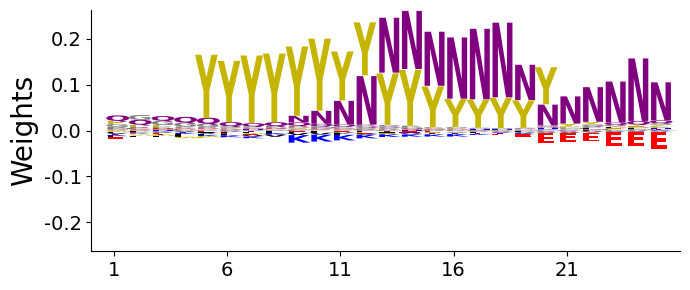

(<Figure size 700x300 with 1 Axes>,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]))

In [ ]:
Sequence_logo_breaks(mat1[max_index])

In [ ]:
weights[2]

(16, 1)

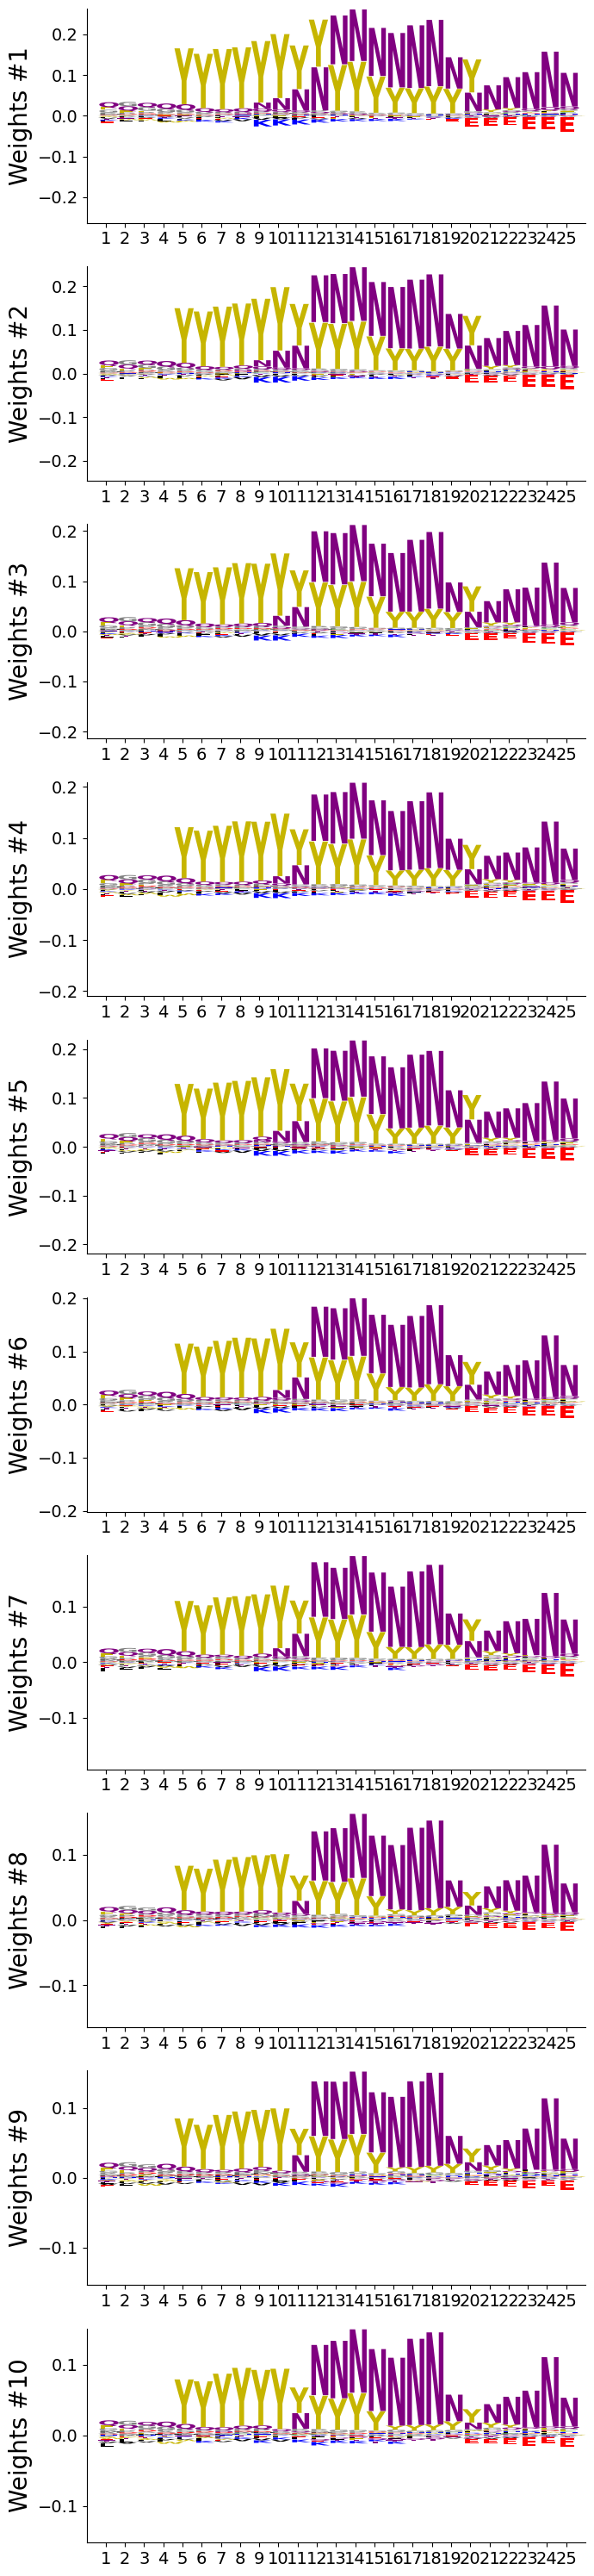

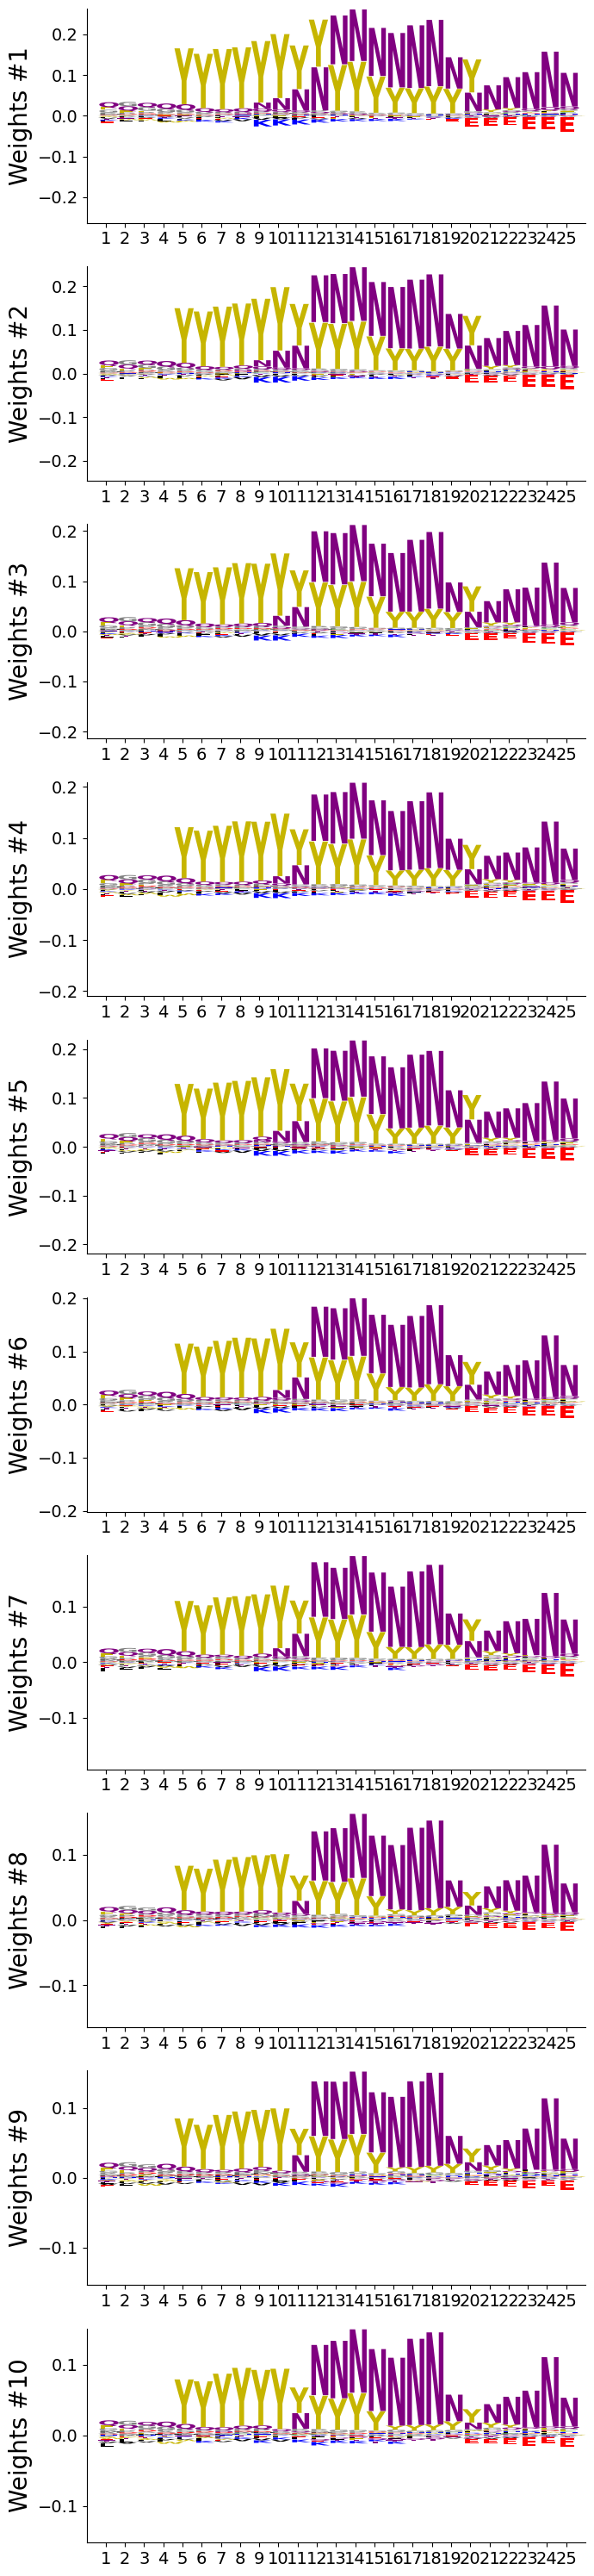

In [ ]:
Sequence_logo_multiple(np.array(mat1)[np.argsort(weights[2][:,0])[::-1][:10]])

In [ ]:
Sequence_logo_breaks(mat1[max_index])

In [ ]:
# Sequence_logo_breaks(model.get_weights()[0])
Sequence_logo_breaks(new_array)

#### Human Genome

In [ ]:
human_genome = load_FASTA("drive/MyDrive/sadna/data/uniprotkb_proteome_UP000005640_AND_revi_2024_02_28.fasta")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# human_genome = load_FASTA("drive/MyDrive/sadna/data/uniprotkb_proteome_UP000005640_AND_revi_2024_02_28.fasta")
human_genes = human_genome[0]
hg_df = pd.DataFrame({"genes": human_genes})
print(hg_df.shape)
hg_df = hg_df[hg_df["genes"].str.len() <= 500] # Todo: change to max_length to see other results
hg_df = hg_df.drop_duplicates()
hg_df = hg_df[~hg_df['genes'].str.contains('[*#UXBZ]')]
human_genes_ohe = one_hot_encode(hg_df["genes"].values, 500) # Todo: change to max_length to see other results

(20418, 1)


In [ ]:
def plot_histogram(model, model_name):
  hg_res = model.predict(human_genes_ohe)
  hg_df["pred"] = hg_res
  hg_df_sorted = hg_df.sort_values(by=["pred"], ascending=False)

  # Plot histogram
  plt.hist(hg_df['pred'], bins=20, edgecolor='black', alpha=0.7)
  plt.xlabel('Probability')
  plt.ylabel('Counts')
  plt.title(f'Probability Histogram For {model_name}')
  plt.show()


In [ ]:
# Todo: deal with prions that are in train
human_prion_1 = "MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG"
human_prion_2 = "MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQITEAQVAENRPGAFIKQGRKLDIDFGAEGNRYYEANYWQFPDGIHYNGCSEANVTKEAFVTGCINATQAANQGEFQKPDNKLHQQVLWRLVQELCSLKHCEFWLERGAGLRVTMHQPVLLCLLALIWLTVK"
human_prion_3 = "MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGASRVRVRPAQRYGAPGSSLRVAAAGAAAGAAAGAAAGLAAGSGWRRAAGPGERGLEDEEDGVPGGNGTGPGIYSYRAWTSGAGPTRGPRLCLVLGGALGALGLLRP"
human_prion_4 = "MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAAPWWWLGTASWWWLGSRRWHPQSVEQAE"
human_prion_5 = "MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTTLPHTAWPLSFLHQTVSTLKAVAVTHSLWHLQIPVDCQACNRKSKKIYC"

In [ ]:
def sequence_rank(df, sequence):
    # Sort the DataFrame by probability in descending order
    df_sorted = df.sort_values(by='pred', ascending=False).reset_index(drop=True)

    # find the index (rank) of the given sequence
    try:
        rank = df_sorted[df_sorted['genes'] == sequence].index[0] + 1
        return rank
    except IndexError:
        return f"Sequence '{sequence}' not found in the DataFrame."


def get_ranks(hg_df):
    print('rank for human prion 1 -' , str(sequence_rank(hg_df, human_prion_1)))
    print('rank for human prion 2 -' , str(sequence_rank(hg_df, human_prion_2)))
    print('rank for human prion 3 -' , str(sequence_rank(hg_df, human_prion_3)))
    print('rank for human prion 4 -' , str(sequence_rank(hg_df, human_prion_4)))
    print('rank for human prion 5 -' , str(sequence_rank(hg_df, human_prion_5)))

384/384 [==============================] - 1s 3ms/step


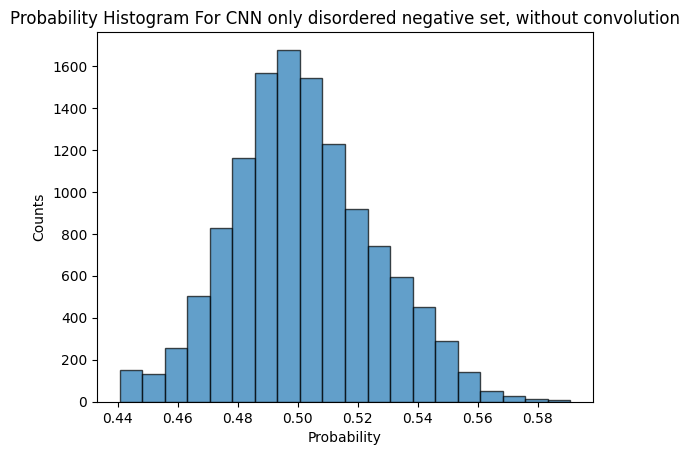

rank for human prion 1 - 3826
rank for human prion 2 - 9832
rank for human prion 3 - 1889
rank for human prion 4 - 4658
rank for human prion 5 - 1295
384/384 [==============================] - 2s 5ms/step


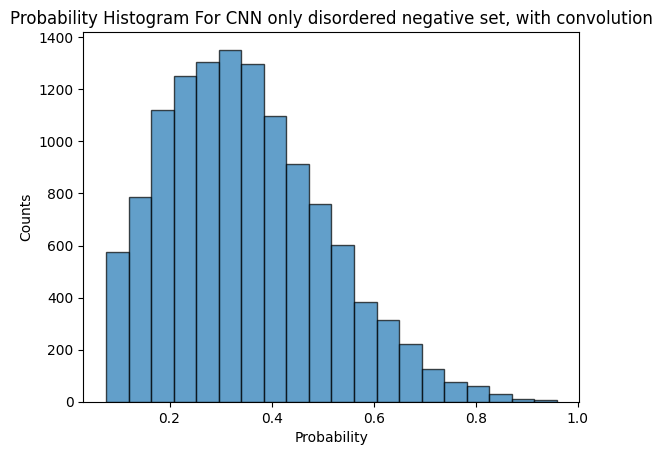

rank for human prion 1 - 41
rank for human prion 2 - 590
rank for human prion 3 - 9454
rank for human prion 4 - 12098
rank for human prion 5 - 11218


In [ ]:
plot_histogram(model_1, "CNN only disordered negative set, without convolution")
get_ranks(hg_df)
plot_histogram(model_2, "CNN only disordered negative set, with convolution")
get_ranks(hg_df)

In [ ]:
len(hg_df)

12281

In [ ]:
plot_histogram(d2_model_1, "CNN globular and disordered negative set, without convolution")
get_ranks(hg_df)
plot_histogram(d2_model_2, "CNN globular and disordered negative set, with convolution")
get_ranks(hg_df)

In [ ]:
human_genome = load_FASTA("drive/MyDrive/sadna/data/uniprotkb_proteome_UP000005640_AND_revi_2024_02_28.fasta")
# print(human_genome[:10])


In [ ]:
# print((human_genome[0][0]))
# print(human_genome[1])
human_genes = human_genome[0]
# model.predict(human_genes)
hg_df = pd.DataFrame({"genes": human_genes})
print(hg_df.shape)
# hg_df.head()
hg_df = hg_df[hg_df["genes"].str.len() <= 500]
print(hg_df.shape)
hg_df = hg_df.drop_duplicates()
print(hg_df.shape)
hg_df = hg_df[~hg_df['genes'].str.contains('[*#UXBZ]')]
print(hg_df.shape)

human_genes_ohe = one_hot_encode(hg_df["genes"].values, 500)


In [ ]:
hg_res = model.predict(human_genes_ohe)
hg_res

In [ ]:
hg_df["pred"] = hg_res
hg_df_sorted = hg_df.sort_values(by=["pred"], ascending=False)
hg_df_sorted.head()


In [ ]:
hg_df_sorted.tail()
# hg_df

In [ ]:
len(hg_df[hg_df["pred"] > 0.5]) / len(hg_df)

In [ ]:
len(hg_df[hg_df["pred"] > 0.6])
# print(hg_df_sorted["genes"].iloc[0])

In [ ]:
human_prion_1 = "MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG"
human_prion_2 = "MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQITEAQVAENRPGAFIKQGRKLDIDFGAEGNRYYEANYWQFPDGIHYNGCSEANVTKEAFVTGCINATQAANQGEFQKPDNKLHQQVLWRLVQELCSLKHCEFWLERGAGLRVTMHQPVLLCLLALIWLTVK"
human_prion_3 = "MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGASRVRVRPAQRYGAPGSSLRVAAAGAAAGAAAGAAAGLAAGSGWRRAAGPGERGLEDEEDGVPGGNGTGPGIYSYRAWTSGAGPTRGPRLCLVLGGALGALGLLRP"
human_prion_4 = "MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAAPWWWLGTASWWWLGSRRWHPQSVEQAE"
human_prion_5 = "MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTTLPHTAWPLSFLHQTVSTLKAVAVTHSLWHLQIPVDCQACNRKSKKIYC"
human_prions = [human_prion_1, human_prion_2, human_prion_3, human_prion_4, human_prion_5]
hg_df[hg_df["genes"].isin(human_prions)]


In [ ]:
# new model (with globular)

In [ ]:
hg_df["pred"] = hg_res
hg_df_sorted = hg_df.sort_values(by=["pred"], ascending=False)
hg_df_sorted.head()

In [ ]:
len(hg_df[hg_df["pred"] > 0.5]) / len(hg_df)

In [ ]:
human_prion_1 = "MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG"
human_prion_2 = "MRKHLSWWWLATVCMLLFSHLSAVQTRGIKHRIKWNRKALPSTAQITEAQVAENRPGAFIKQGRKLDIDFGAEGNRYYEANYWQFPDGIHYNGCSEANVTKEAFVTGCINATQAANQGEFQKPDNKLHQQVLWRLVQELCSLKHCEFWLERGAGLRVTMHQPVLLCLLALIWLTVK"
human_prion_3 = "MNWAPATCWALLLAAAFLCDSGAAKGGRGGARGSARGGVRGGARGASRVRVRPAQRYGAPGSSLRVAAAGAAAGAAAGAAAGLAAGSGWRRAAGPGERGLEDEEDGVPGGNGTGPGIYSYRAWTSGAGPTRGPRLCLVLGGALGALGLLRP"
human_prion_4 = "MEHWGQPIPGAGQPWRQPLPTSGRWWLGAASWWWLGAASWWWLGAAPWWWLGTASWWWLGSRRWHPQSVEQAE"
human_prion_5 = "MQHSLVFFFAVILHLSHLLHLDASIHPFRLPFSSKPFLLIPMSNTTLPHTAWPLSFLHQTVSTLKAVAVTHSLWHLQIPVDCQACNRKSKKIYC"
human_prions = [human_prion_1, human_prion_2, human_prion_3, human_prion_4, human_prion_5]
hg_df[hg_df["genes"].isin(human_prions)]

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test_one_hot_sequences)

# Convert predictions to binary classes (thresholding at 0.5 for sigmoid activation)
y_pred = y_pred > 0.5

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


disp=ConfusionMatrixDisplay(cm,display_labels=['Disordered','Prion'])
disp.plot()
plt.show()


#### Second Model Attempt


In [ ]:

# Build the CNN model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 20)))  # Masking layer for variable length sequences
model.add(AveragePooling1D(pool_size=30, strides=1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=10, batch_size=16, validation_data=(X_eval_one_hot_sequences, y_validation.values.astype(int)))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

weights = model.get_weights()
# print(weights)

In [ ]:
logo_weights = weights[0]
Sequence_logo_breaks(logo_weights)

#### Check Motifs with CNN

In [ ]:
from keras.callbacks import EarlyStopping

def CNN_motifs(X_train_one_hot_sequences,y_train,X_eval_one_hot_sequences,y_validation):
# Build the CNN model
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, 20)))
    model.add(Conv1D(filters=num_filter, kernel_size=kernel_size, activation='relu'))
    model.add(AveragePooling1D(pool_size=30, strides=1))
    model.add(Dense(1, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=30, batch_size=16, validation_data=(X_eval_one_hot_sequences, y_validation.values.astype(int)), callbacks=[early_stopping])
    return history

# Define parameters
kernel_sizes = [20, 25, 30]
num_filters = [128, 256]  # You can adjust this based on your requirements

best_loss = float('inf')
best_params = None

for kernel_size in kernel_sizes:
    for num_filter in num_filters:
      history = CNN_motifs(X_train_one_hot_sequences,y_train,X_eval_one_hot_sequences,y_validation)

      # Check if the current model has the best validation loss
      if history.history['val_loss'][-1] < best_loss:
          best_loss = history.history['val_loss'][-1]
          best_params = (kernel_size, num_filter)

# Print the best parameters
print("Best parameters (kernel size, num_filters):", best_params)






In [ ]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 20)))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(AveragePooling1D(pool_size=30, strides=1))
model.add(Dense(1, activation='sigmoid'))
model.add(GlobalMaxPooling1D())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model
model.fit(X_train_one_hot_sequences, y_train.values.astype(int), epochs=30, batch_size=16, validation_data=(X_eval_one_hot_sequences, y_validation.values.astype(int)), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_one_hot_sequences, y_test.values.astype(int))
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

In [ ]:
# Assuming you have trained your model and stored it in the variable 'model'

# Step 1: Extract weights of the convolutional layer
conv_weights = model.layers[1].get_weights()[0]

# Step 2: Reshape weights if necessary (depends on the shape of your weights)

# Step 3: Visualize the weights of each convolutional filter
print("Visualizing weights of each convolutional filter:")
print()
fig, axes = plt.subplots(nrows=len(conv_weights), figsize=(10, 5*len(conv_weights)))
for i, weights in enumerate(conv_weights):
    print("Processing filter", i+1)
    print("Shape of weights:", weights.shape)
    print("Min value:", weights.min())
    print("Max value:", weights.max())

    # Reshape the weights into a 20x128 array
    reshaped_weights = weights.reshape(20, -1)

    # Create a new subplot for each filter
    ax = axes[i]

    # Visualize the weights using Sequence_logo_breaks
    Sequence_logo_breaks(reshaped_weights, figsize=(15, 3), ylabel='Weights', title=f'Filter {i+1}')
    print("Plot generated for filter", i+1)
    print()

# Step 4: Interpretation
print("Interpretation:")
print("The plots above visualize the importance of each amino acid for each convolutional filter.")


#### Parsing Clusters and Creating Graphs: NO GO

In [ ]:
disport_cluster_output_file = 'disprot_cluster_output_cluster.tsv'
prion_cluster_output_file = 'prion_cluster_output_cluster.tsv'

disport_clusters = parse_cluster_output(disport_cluster_output_file)
prion_clusters = parse_cluster_output(prion_cluster_output_file)

G_disport = create_graph(disport_clusters)
G_prion = create_graph(prion_clusters)

In [ ]:
nx.draw(G_prion, with_labels=True)

#### Creating Connected components NO GO

In [ ]:
adj_matrix_disport = nx.to_numpy_array(G_disport)
adj_matrix_disport[adj_matrix_disport > 0] = 1  # Convert to binary adjacency matrix
n_components_disport, labels_disport = connected_components(csgraph=csr_matrix(adj_matrix_disport), directed=False)

In [ ]:
adj_matrix_prion = nx.to_numpy_array(G_prion)
adj_matrix_prion[adj_matrix_prion > 0] = 1  # Convert to binary adjacency matrix
n_components_prion, labels_prion = connected_components(csgraph=csr_matrix(adj_matrix_prion), directed=False)


#### Here we'll randomly assign components to train, validation, or test
No GO


In [ ]:
n_samples = len(G_disport.nodes)
component_indices = np.arange(n_samples)
np.random.shuffle(component_indices)

train_indices = component_indices[:int(0.7 * n_samples)]
val_indices = component_indices[int(0.7 * n_samples):int(0.85 * n_samples)]
test_indices = component_indices[int(0.85 * n_samples):]

train_components = [component for i, component in enumerate(labels) if i in train_indices]
val_components = [component for i, component in enumerate(labels) if i in val_indices]
test_components = [component for i, component in enumerate(labels) if i in test_indices]

## Data and Libs

In [ ]:
# Get data and relevant libs from here
# !pip install biopython==1.79 ipython jupyter==1.0.0 matplotlib numpy pandas scikit-learn torch seaborn
# !wget "https://disprot.org/api/search?release=2022_06&show_ambiguous=true&show_obsolete=false&format=fasta&namespace=all&get_consensus=false" -O disprot.fasta
# !wget http://download.cathdb.info/cath/releases/all-releases/v4_3_0/sequence-data/cath-domain-seqs-S35-v4_3_0.fa -O cath.fasta



### **Create protein sequence dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    all_labels = []
    with open(filename, 'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
                all_labels.append(line[1:].replace('\n', '').replace('\r', ''))
            else:
                current_seq += line.replace('\n', '').replace('\r', '')
                count += 1
        all_seqs.append(current_seq)
        all_seqs = np.array(all_seqs[1:])
        all_seqs = np.array(all_seqs)
    return all_seqs, np.array(all_labels)


# ordered_proteins, ordered_protein_labels = load_FASTA(r'cath.fasta')
# print(type(ordered_proteins))
# print(ordered_protein_labels[:5])
disordered_proteins, disordered_protein_labels = load_FASTA(r'disprot.fasta')

prion_db = pd.read_csv(r"prion_db.csv")
print(f"Number of prion seqs: {len(prion_db)}\n")
prions = prion_db["Sequence"]
# print(prion_db["Sequence Length"].mean())


print('Sample prion:\n' ,prions[10])
print()
print('Sample disordered protein:\n' ,disordered_proteins[10])
print()

print('Number of ordered protein sequences: %s' % len(prions))
print('Number of disordered protein sequences: %s' % len(disordered_proteins))

FileNotFoundError: [Errno 2] No such file or directory: 'disprot.fasta'

In [ ]:
disordered_protein_labels

NameError: name 'disordered_protein_labels' is not defined